In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [ ]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [ ]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [ ]:
REWARD = 10

In [ ]:
seed = 985
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [ ]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

In [ ]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [ ]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [ ]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

In [ ]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-5  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [ ]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

In [ ]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [ ]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [ ]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [ ]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

In [ ]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((node_id%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [ ]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [ ]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

In [ ]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table

LOSS : 2.948	LOSS : 2.748	LOSS : 2.547	LOSS : 2.303	LOSS : 2.412	LOSS : 2.400	LOSS : 2.915	LOSS : 2.340	LOSS : 2.948	LOSS : 3.070	LOSS : 3.189	LOSS : 2.405	LOSS : 2.706	LOSS : 2.494	LOSS : 2.733	LOSS : 2.658	LOSS : 2.904	LOSS : 3.009	LOSS : 2.714	
Validating... MEAN TIME:  105.97
LOSS : 2.588	LOSS : 2.109	LOSS : 2.603	LOSS : 3.138	LOSS : 2.925	LOSS : 2.723	LOSS : 2.337	LOSS : 2.752	LOSS : 3.158	LOSS : 2.768	LOSS : 2.630	LOSS : 2.504	LOSS : 2.513	LOSS : 2.496	LOSS : 2.269	LOSS : 2.666	LOSS : 2.602	LOSS : 2.160	LOSS : 2.340	LOSS : 2.747	LOSS : 2.568	LOSS : 2.648	LOSS : 2.271	LOSS : 2.522	LOSS : 2.396	LOSS : 2.472	LOSS : 2.388	LOSS : 2.601	LOSS : 2.394	LOSS : 2.744	
Validating... MEAN TIME:  101.915
TRAINING TIME:0:00:42.422598


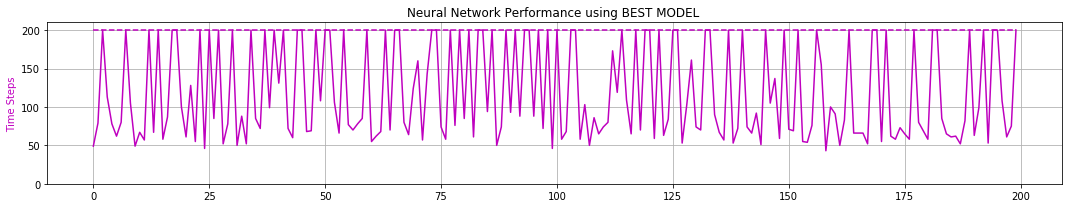

peak memory: 1379.41 MiB, increment: 1014.33 MiB
0 -max- [ 0.309  0.956  0.209  1.619]
0 -min- [-0.440 -1.018 -0.207 -0.945]

1 -max- [ 0.795  1.623  0.209  0.771]
1 -min- [-0.396 -0.719 -0.209 -0.949]

2 -max- [ 0.379  1.070  0.209  1.314]
2 -min- [-0.370 -0.810 -0.209 -0.917]

3 -max- [ 0.588  1.141  0.209  0.756]
3 -min- [-0.255 -0.578 -0.209 -0.936]

4 -max- [ 0.373  1.066  0.209  1.162]
4 -min- [-0.687 -0.775 -0.209 -0.898]

5 -max- [ 2.382  2.799  0.209  0.769]
5 -min- [-0.267 -0.577 -0.209 -1.604]

6 -max- [ 0.355  0.957  0.209  1.059]
6 -min- [-0.276 -0.736 -0.209 -0.935]

7 -max- [ 0.699  1.505  0.209  0.786]
7 -min- [-0.316 -0.577 -0.209 -0.947]

8 -max- [ 0.369  1.074  0.209  0.878]
8 -min- [-0.313 -0.699 -0.209 -0.783]

9 -max- [ 0.418  1.112  0.209  0.780]
9 -min- [-0.659 -0.742 -0.209 -0.925]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 37
REAL TIME TO GENERATE 66823 EXPERIENCES:0:00:01.514956


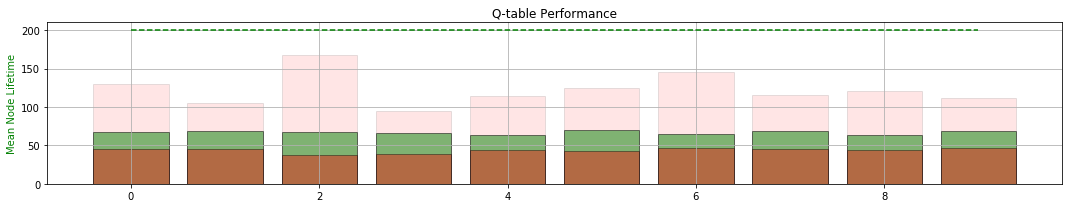

MEMORY COUNTER:  295148
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.248	LOSS : 2.440	LOSS : 2.296	LOSS : 2.402	LOSS : 2.728	LOSS : 2.575	LOSS : 2.220	LOSS : 2.111	LOSS : 2.474	LOSS : 2.469	LOSS : 2.041	LOSS : 2.585	LOSS : 2.606	LOSS : 2.338	LOSS : 2.021	LOSS : 2.045	LOSS : 2.674	LOSS : 2.326	LOSS : 2.637	LOSS : 2.274	LOSS : 2.130	LOSS : 2.556	LOSS : 2.081	LOSS : 2.326	LOSS : 1.910	LOSS : 2.331	LOSS : 2.264	LOSS : 2.711	LOSS : 2.151	LOSS : 2.119	
Validating... MEAN TIME:  98.27
LOSS : 2.379	LOSS : 2.513	LOSS : 2.413	LOSS : 2.245	LOSS : 2.556	LOSS : 2.722	LOSS : 2.446	LOSS : 2.551	LOSS : 2.052	LOSS : 2.098	LOSS : 2.723	LOSS : 2.162	LOSS : 1.936	LOSS : 2.606	LOSS : 2.066	LOSS : 2.266	LOSS : 2.198	LOSS : 2.331	LOSS : 2.083	LOSS : 2.547	LOSS : 2.397	LOSS : 2.324	LOSS : 2.309	LOSS : 2.112	LOSS : 2.821	LOSS : 2.875	LOSS : 2.000	LOSS : 2.393	LOSS : 2.143	LOSS : 2.187	
Validating... MEAN TIME:  96.99
LOSS : 2.667	LOSS : 2.160

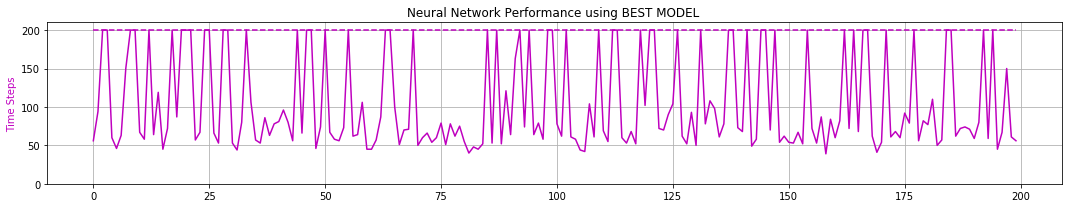

peak memory: 1367.73 MiB, increment: 990.60 MiB
0 -max- [ 0.377  1.056  0.209  1.077]
0 -min- [-0.486 -0.760 -0.209 -0.912]

1 -max- [ 0.532  1.108  0.209  0.785]
1 -min- [-0.337 -0.575 -0.209 -1.088]

2 -max- [ 0.390  1.086  0.209  1.154]
2 -min- [-1.023 -0.964 -0.209 -0.885]

3 -max- [ 0.567  1.297  0.209  0.807]
3 -min- [-0.311 -0.577 -0.209 -0.983]

4 -max- [ 0.380  1.084  0.209  1.047]
4 -min- [-0.312 -0.724 -0.208 -0.841]

5 -max- [ 0.506  1.145  0.209  0.764]
5 -min- [-0.414 -0.576 -0.209 -1.236]

6 -max- [ 0.380  1.042  0.209  1.360]
6 -min- [-0.430 -0.771 -0.209 -0.873]

7 -max- [ 0.543  1.316  0.209  0.751]
7 -min- [-0.301 -0.577 -0.209 -1.170]

8 -max- [ 0.382  1.087  0.209  1.072]
8 -min- [-0.308 -0.739 -0.208 -0.852]

9 -max- [ 0.514  1.124  0.209  0.779]
9 -min- [-0.261 -0.577 -0.207 -0.912]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 38
REAL TIME TO GENERATE 64882 EXPERIENCES:0:00:01.590563


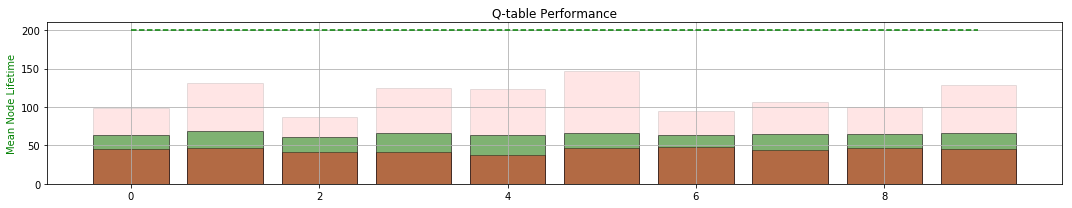

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.708	LOSS : 1.896	LOSS : 1.579	LOSS : 2.120	LOSS : 1.533	LOSS : 1.415	LOSS : 1.949	LOSS : 2.175	LOSS : 1.739	LOSS : 1.895	LOSS : 1.935	LOSS : 1.609	LOSS : 2.089	LOSS : 2.009	LOSS : 1.970	LOSS : 1.740	LOSS : 1.920	LOSS : 1.812	LOSS : 1.707	LOSS : 1.913	LOSS : 1.963	LOSS : 1.879	LOSS : 2.159	LOSS : 2.279	LOSS : 1.736	LOSS : 2.002	LOSS : 1.865	LOSS : 2.073	LOSS : 2.341	LOSS : 1.895	
Validating... MEAN TIME:  118.705
LOSS : 1.556	LOSS : 2.114	LOSS : 1.946	LOSS : 2.345	LOSS : 1.824	LOSS : 2.030	LOSS : 1.763	LOSS : 2.391	LOSS : 2.598	LOSS : 1.751	LOSS : 1.820	LOSS : 2.000	LOSS : 2.105	LOSS : 1.944	LOSS : 1.917	LOSS : 1.332	LOSS : 1.894	LOSS : 1.637	LOSS : 2.275	LOSS : 2.401	LOSS : 1.869	LOSS : 1.822	LOSS : 2.128	LOSS : 1.835	LOSS : 2.277	LOSS : 2.624	LOSS : 2.097	LOSS : 1.719	LOSS : 1.858	LOSS : 1.497	
Validating... MEAN TIME:  108.65
LOSS : 1.484	LOSS : 1.

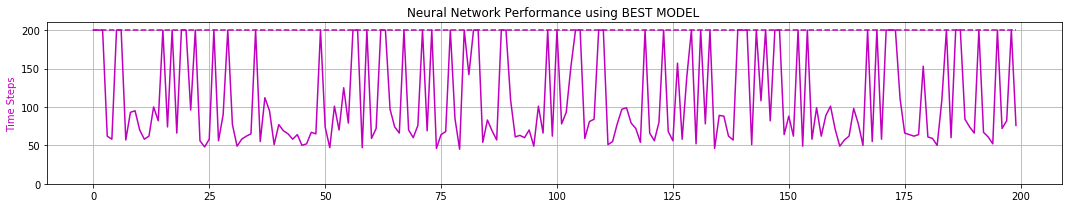

peak memory: 1453.30 MiB, increment: 1014.07 MiB
0 -max- [ 0.353  0.776  0.209  1.042]
0 -min- [-0.353 -0.760 -0.209 -0.893]

1 -max- [ 0.403  1.059  0.209  0.801]
1 -min- [-0.255 -0.574 -0.209 -0.916]

2 -max- [ 0.314  0.779  0.209  1.192]
2 -min- [-0.354 -0.776 -0.208 -0.872]

3 -max- [ 0.382  0.939  0.209  0.799]
3 -min- [-0.343 -0.727 -0.209 -1.301]

4 -max- [ 0.341  0.777  0.209  1.045]
4 -min- [-0.397 -0.768 -0.209 -0.869]

5 -max- [ 0.467  0.964  0.209  0.772]
5 -min- [-0.340 -0.577 -0.209 -1.075]

6 -max- [ 0.333  0.780  0.209  0.935]
6 -min- [-0.394 -0.748 -0.205 -0.959]

7 -max- [ 0.383  0.926  0.209  0.764]
7 -min- [-0.268 -0.577 -0.209 -0.873]

8 -max- [ 0.341  0.780  0.209  1.098]
8 -min- [-0.286 -0.697 -0.209 -0.926]

9 -max- [ 0.371  0.949  0.209  0.777]
9 -min- [-0.282 -0.575 -0.209 -0.994]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 30
REAL TIME TO GENERATE 74334 EXPERIENCES:0:00:01.848007


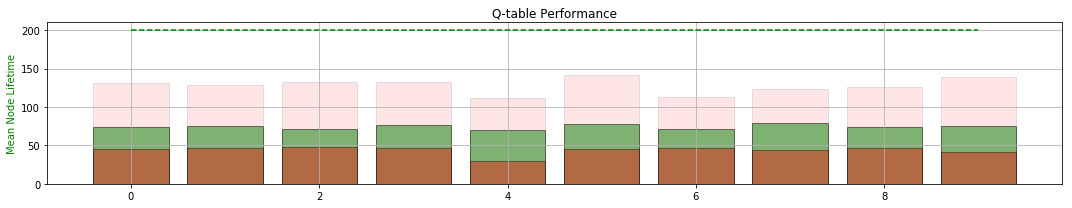

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.094	LOSS : 1.746	LOSS : 1.559	LOSS : 1.977	LOSS : 1.827	LOSS : 1.650	LOSS : 1.471	LOSS : 1.682	LOSS : 1.508	LOSS : 1.962	LOSS : 1.817	LOSS : 1.729	LOSS : 1.610	LOSS : 1.655	LOSS : 1.536	LOSS : 1.702	LOSS : 1.953	LOSS : 2.076	LOSS : 1.314	LOSS : 1.652	LOSS : 1.497	LOSS : 2.014	LOSS : 1.642	LOSS : 1.760	LOSS : 1.948	LOSS : 2.188	LOSS : 1.465	LOSS : 1.345	LOSS : 2.033	LOSS : 2.292	
Validating... MEAN TIME:  107.005
LOSS : 1.779	LOSS : 1.687	LOSS : 1.803	LOSS : 1.598	LOSS : 1.881	LOSS : 1.356	LOSS : 1.969	LOSS : 1.902	LOSS : 1.803	LOSS : 1.716	LOSS : 2.051	LOSS : 1.745	LOSS : 1.929	LOSS : 1.822	LOSS : 2.207	LOSS : 1.789	LOSS : 1.581	LOSS : 1.551	LOSS : 2.359	LOSS : 1.505	LOSS : 1.562	LOSS : 2.082	LOSS : 1.882	LOSS : 1.910	LOSS : 1.832	LOSS : 1.996	LOSS : 1.513	LOSS : 1.993	LOSS : 1.891	LOSS : 1.751	
Validating... MEAN TIME:  100.715
LOSS : 1.682	LOSS : 1

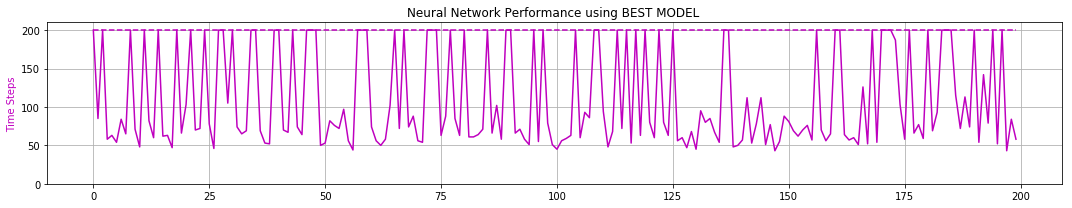

peak memory: 1457.56 MiB, increment: 1017.62 MiB
0 -max- [ 0.445  0.913  0.209  1.045]
0 -min- [-0.321 -0.672 -0.209 -0.885]

1 -max- [ 0.570  1.138  0.209  0.787]
1 -min- [-0.268 -0.576 -0.209 -0.924]

2 -max- [ 0.364  0.777  0.209  1.047]
2 -min- [-0.359 -0.744 -0.208 -0.869]

3 -max- [ 0.576  0.966  0.209  0.777]
3 -min- [-0.377 -0.575 -0.209 -0.985]

4 -max- [ 0.377  0.778  0.209  1.228]
4 -min- [-0.367 -0.746 -0.209 -0.844]

5 -max- [ 0.439  0.953  0.209  0.798]
5 -min- [-0.316 -0.578 -0.209 -1.170]

6 -max- [ 0.359  0.780  0.209  0.955]
6 -min- [-0.273 -0.694 -0.206 -0.823]

7 -max- [ 0.601  0.961  0.209  0.799]
7 -min- [-0.262 -0.576 -0.208 -0.987]

8 -max- [ 0.418  0.775  0.209  1.125]
8 -min- [-0.311 -0.755 -0.208 -0.843]

9 -max- [ 0.580  0.954  0.209  0.796]
9 -min- [-0.272 -0.577 -0.208 -1.035]

Quantization TIME:  0.02 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 43
REAL TIME TO GENERATE 74122 EXPERIENCES:0:00:01.755495


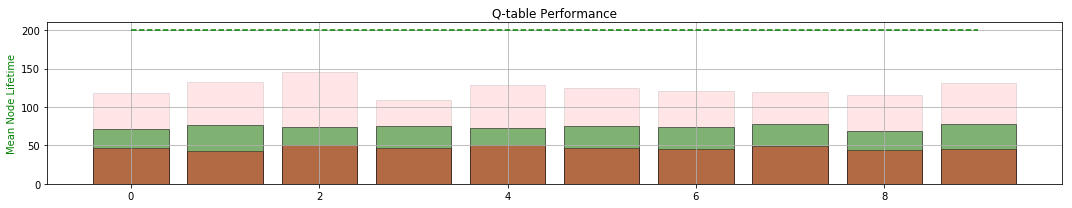

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.716	LOSS : 1.491	LOSS : 1.536	LOSS : 1.866	LOSS : 1.854	LOSS : 1.619	LOSS : 1.628	LOSS : 1.548	LOSS : 1.948	LOSS : 1.527	LOSS : 1.566	LOSS : 1.623	LOSS : 1.552	LOSS : 1.647	LOSS : 1.752	LOSS : 1.611	LOSS : 1.408	LOSS : 1.505	LOSS : 1.847	LOSS : 1.516	LOSS : 1.554	LOSS : 1.844	LOSS : 1.888	LOSS : 1.757	LOSS : 1.700	LOSS : 1.700	LOSS : 1.171	LOSS : 1.437	LOSS : 1.331	LOSS : 2.118	
Validating... MEAN TIME:  105.275
LOSS : 2.039	LOSS : 2.060	LOSS : 1.780	LOSS : 1.676	LOSS : 1.381	LOSS : 1.643	LOSS : 1.693	LOSS : 1.998	LOSS : 1.519	LOSS : 1.603	LOSS : 1.621	LOSS : 1.835	LOSS : 1.392	LOSS : 1.664	LOSS : 1.479	LOSS : 1.986	LOSS : 1.425	LOSS : 1.621	LOSS : 1.316	LOSS : 1.659	LOSS : 1.273	LOSS : 1.615	LOSS : 1.580	LOSS : 2.059	LOSS : 1.474	LOSS : 1.799	LOSS : 1.783	LOSS : 1.592	LOSS : 1.290	LOSS : 1.713	
Validating... MEAN TIME:  99.425
LOSS : 1.403	LOSS : 1.

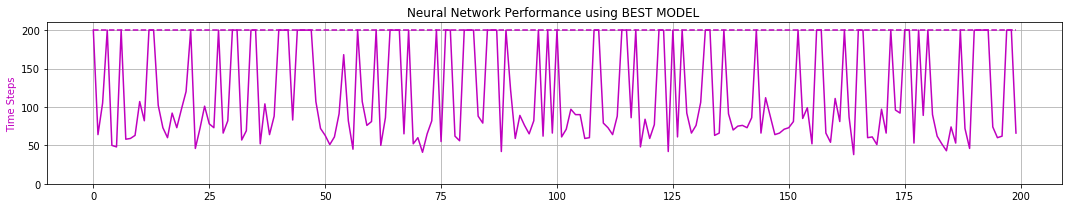

peak memory: 1406.38 MiB, increment: 1025.14 MiB
0 -max- [ 0.449  0.945  0.209  1.211]
0 -min- [-0.407 -0.758 -0.208 -0.897]

1 -max- [ 0.512  1.132  0.209  0.792]
1 -min- [-0.310 -0.577 -0.209 -1.323]

2 -max- [ 0.410  0.778  0.209  1.136]
2 -min- [-0.395 -0.717 -0.207 -0.831]

3 -max- [ 0.573  1.104  0.209  0.782]
3 -min- [-0.356 -0.746 -0.209 -1.017]

4 -max- [ 0.397  0.778  0.209  1.014]
4 -min- [-0.316 -0.729 -0.209 -0.834]

5 -max- [ 0.418  1.098  0.209  0.772]
5 -min- [-0.272 -0.577 -0.209 -1.073]

6 -max- [ 0.397  0.778  0.209  1.129]
6 -min- [-0.308 -0.575 -0.209 -0.884]

7 -max- [ 0.505  0.944  0.209  0.795]
7 -min- [-0.311 -0.576 -0.209 -0.830]

8 -max- [ 0.401  0.778  0.209  1.175]
8 -min- [-0.314 -0.760 -0.209 -0.848]

9 -max- [ 0.603  0.943  0.209  0.789]
9 -min- [-0.295 -0.577 -0.209 -1.169]

Quantization TIME:  0.01 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 39
REAL TIME TO GENERATE 74826 EXPERIENCES:0:00:01.771461


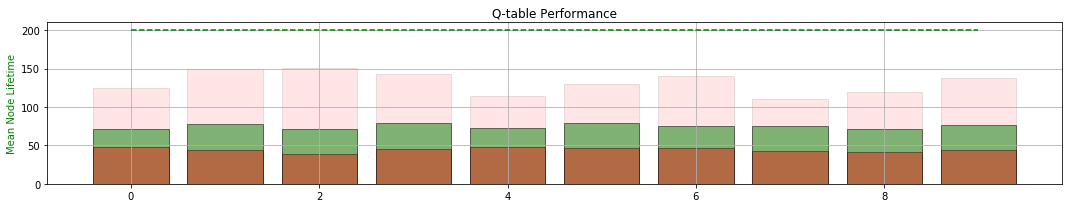

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.323	LOSS : 1.761	LOSS : 1.472	LOSS : 1.727	LOSS : 1.862	LOSS : 1.113	LOSS : 1.406	LOSS : 1.734	LOSS : 1.510	LOSS : 1.654	LOSS : 1.616	LOSS : 1.580	LOSS : 1.687	LOSS : 1.450	LOSS : 1.682	LOSS : 1.746	LOSS : 1.196	LOSS : 1.705	LOSS : 1.407	LOSS : 1.952	LOSS : 1.772	LOSS : 1.353	LOSS : 1.336	LOSS : 1.523	LOSS : 1.184	LOSS : 1.677	LOSS : 1.309	LOSS : 1.185	LOSS : 1.104	LOSS : 1.518	
Validating... MEAN TIME:  92.71
LOSS : 1.226	LOSS : 1.765	LOSS : 1.661	LOSS : 1.668	LOSS : 1.587	LOSS : 1.357	LOSS : 1.905	LOSS : 1.433	LOSS : 1.580	LOSS : 1.404	LOSS : 1.844	LOSS : 2.023	LOSS : 1.351	LOSS : 1.584	LOSS : 1.592	LOSS : 1.606	LOSS : 1.293	LOSS : 1.380	LOSS : 1.554	LOSS : 1.366	LOSS : 1.363	LOSS : 1.612	LOSS : 1.791	LOSS : 1.753	LOSS : 1.399	LOSS : 2.030	LOSS : 1.586	LOSS : 1.566	LOSS : 1.125	LOSS : 1.321	
Validating... MEAN TIME:  105.245
LOSS : 1.496	LOSS : 1.5

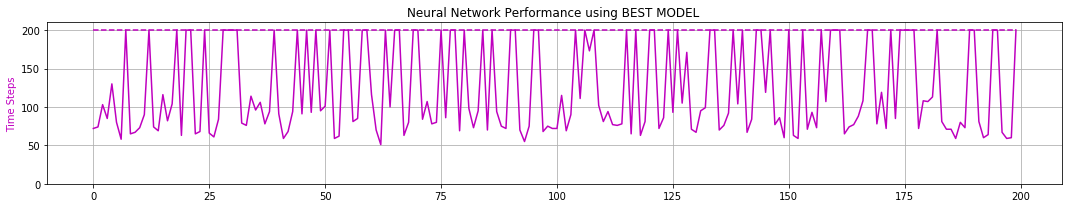

peak memory: 1447.28 MiB, increment: 1017.37 MiB
0 -max- [ 0.374  0.778  0.209  1.031]
0 -min- [-0.292 -0.743 -0.209 -0.867]

1 -max- [ 0.414  1.077  0.209  0.806]
1 -min- [-0.436 -0.774 -0.209 -0.870]

2 -max- [ 0.396  0.779  0.209  1.151]
2 -min- [-0.368 -0.765 -0.209 -0.832]

3 -max- [ 0.562  0.971  0.209  0.778]
3 -min- [-0.287 -0.576 -0.209 -1.170]

4 -max- [ 0.391  0.779  0.209  1.007]
4 -min- [-0.463 -0.760 -0.207 -0.828]

5 -max- [ 0.542  0.970  0.209  0.803]
5 -min- [-0.289 -0.575 -0.209 -0.877]

6 -max- [ 0.387  0.775  0.209  1.125]
6 -min- [-0.428 -0.966 -0.209 -0.923]

7 -max- [ 0.541  0.957  0.209  0.808]
7 -min- [-0.270 -0.576 -0.209 -0.972]

8 -max- [ 0.370  0.779  0.209  1.101]
8 -min- [-0.363 -0.752 -0.209 -0.909]

9 -max- [ 0.592  0.960  0.209  0.773]
9 -min- [-0.283 -0.576 -0.209 -1.079]

Quantization TIME:  0.01 minutes


ITERATION # 10
SMALLEST TIMESTEP in ITERATION 10: 39
REAL TIME TO GENERATE 75595 EXPERIENCES:0:00:01.745849


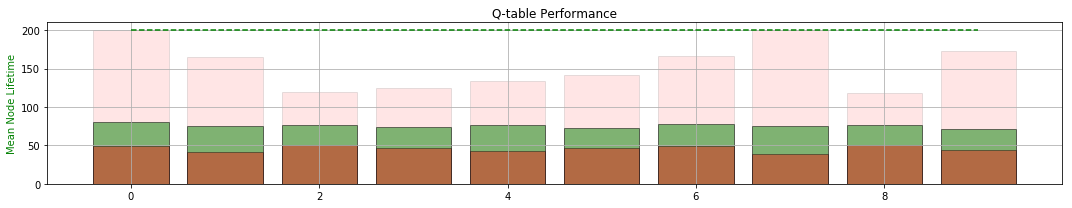

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.400	LOSS : 1.542	LOSS : 1.520	LOSS : 1.889	LOSS : 1.651	LOSS : 1.552	LOSS : 1.742	LOSS : 1.314	LOSS : 1.441	LOSS : 1.811	LOSS : 1.623	LOSS : 1.196	LOSS : 1.582	LOSS : 1.408	LOSS : 1.550	LOSS : 1.258	LOSS : 1.489	LOSS : 1.430	LOSS : 1.790	LOSS : 1.693	LOSS : 1.921	LOSS : 1.342	LOSS : 1.533	LOSS : 1.513	LOSS : 1.673	LOSS : 1.441	LOSS : 1.555	LOSS : 1.671	LOSS : 1.535	LOSS : 1.625	
Validating... MEAN TIME:  107.995
LOSS : 1.804	LOSS : 1.413	LOSS : 1.291	LOSS : 1.701	LOSS : 1.294	LOSS : 1.998	LOSS : 1.445	LOSS : 1.639	LOSS : 1.369	LOSS : 1.372	LOSS : 1.506	LOSS : 1.801	LOSS : 1.146	LOSS : 1.506	LOSS : 1.396	LOSS : 1.323	LOSS : 1.391	LOSS : 1.478	LOSS : 1.836	LOSS : 1.643	LOSS : 1.795	LOSS : 1.415	LOSS : 1.496	LOSS : 1.382	LOSS : 1.589	LOSS : 1.566	LOSS : 1.247	LOSS : 1.588	LOSS : 1.531	LOSS : 1.799	
Validating... MEAN TIME:  106.78
LOSS : 1.548	LOSS : 1.

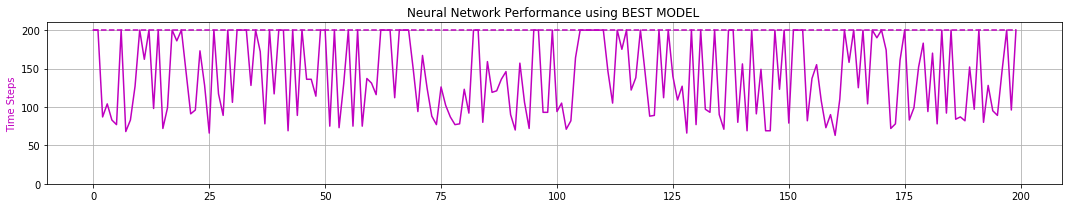

peak memory: 1385.46 MiB, increment: 1017.25 MiB
0 -max- [ 1.932  1.487  0.209  0.943]
0 -min- [-0.382 -1.098 -0.209 -0.809]

1 -max- [ 2.381  2.379  0.209  0.679]
1 -min- [-0.360 -0.772 -0.209 -1.172]

2 -max- [ 0.798  1.429  0.209  0.838]
2 -min- [-0.377 -0.957 -0.209 -0.806]

3 -max- [ 2.390  2.723  0.209  0.573]
3 -min- [-0.331 -0.776 -0.209 -1.048]

4 -max- [ 0.981  1.622  0.209  0.731]
4 -min- [-0.562 -0.918 -0.209 -0.806]

5 -max- [ 2.395  2.726  0.208  0.644]
5 -min- [-0.351 -0.773 -0.209 -1.038]

6 -max- [ 2.390  1.654  0.209  0.891]
6 -min- [-0.376 -0.948 -0.209 -0.805]

7 -max- [ 2.399  2.575  0.207  0.490]
7 -min- [-0.325 -0.779 -0.209 -1.330]

8 -max- [ 0.867  1.457  0.209  1.030]
8 -min- [-0.426 -0.956 -0.209 -0.804]

9 -max- [ 2.378  2.936  0.209  0.608]
9 -min- [-0.376 -0.779 -0.209 -1.070]

Quantization TIME:  0.01 minutes


ITERATION # 11
SMALLEST TIMESTEP in ITERATION 11: 40
REAL TIME TO GENERATE 72077 EXPERIENCES:0:00:01.639263


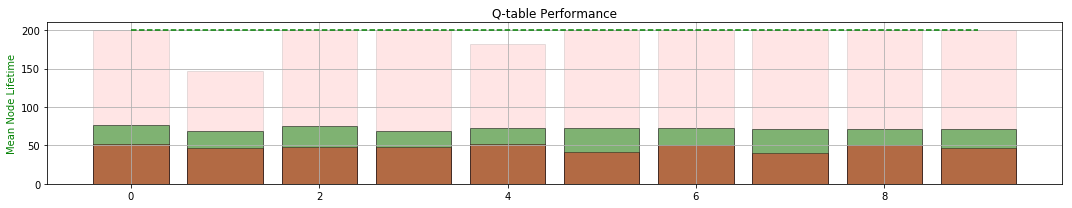

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.729	LOSS : 1.543	LOSS : 1.422	LOSS : 1.365	LOSS : 1.770	LOSS : 1.845	LOSS : 1.905	LOSS : 1.478	LOSS : 1.565	LOSS : 1.444	LOSS : 1.874	LOSS : 1.642	LOSS : 1.908	LOSS : 1.796	LOSS : 1.155	LOSS : 1.979	LOSS : 1.458	LOSS : 2.165	LOSS : 1.337	LOSS : 1.291	LOSS : 1.383	LOSS : 1.830	LOSS : 1.261	LOSS : 0.861	LOSS : 1.462	LOSS : 2.001	LOSS : 1.578	LOSS : 1.621	LOSS : 1.361	LOSS : 1.969	
Validating... MEAN TIME:  137.51
LOSS : 2.086	LOSS : 1.311	LOSS : 1.559	LOSS : 1.892	LOSS : 1.415	LOSS : 1.489	LOSS : 1.589	LOSS : 1.698	LOSS : 1.373	LOSS : 1.863	LOSS : 1.948	LOSS : 1.325	LOSS : 1.662	LOSS : 1.500	LOSS : 1.502	LOSS : 1.521	LOSS : 1.676	LOSS : 2.046	LOSS : 1.465	LOSS : 1.792	LOSS : 1.488	LOSS : 1.655	LOSS : 1.836	LOSS : 1.647	LOSS : 1.299	LOSS : 1.739	LOSS : 1.607	LOSS : 1.707	LOSS : 1.037	LOSS : 1.534	
Validating... MEAN TIME:  162.56
LOSS : 1.579	LOSS : 1.7

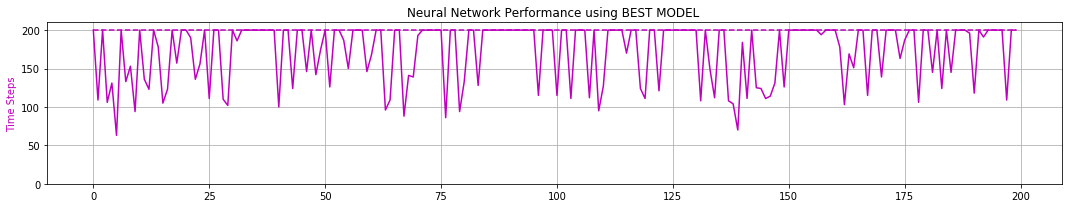

peak memory: 1404.92 MiB, increment: 987.76 MiB
0 -max- [ 2.393  2.941  0.209  0.795]
0 -min- [-0.424 -0.969 -0.209 -0.749]

1 -max- [ 2.384  2.877  0.208  0.487]
1 -min- [-0.303 -0.778 -0.209 -0.980]

2 -max- [ 2.400  2.949  0.209  0.724]
2 -min- [-0.400 -0.958 -0.209 -0.777]

3 -max- [ 1.393  1.429  0.207  0.494]
3 -min- [-0.297 -0.782 -0.209 -1.113]

4 -max- [ 0.796  1.471  0.209  0.722]
4 -min- [-0.502 -0.951 -0.209 -0.766]

5 -max- [ 1.139  1.448  0.209  0.477]
5 -min- [-0.328 -0.778 -0.209 -1.090]

6 -max- [ 1.551  1.474  0.209  0.819]
6 -min- [-0.690 -1.273 -0.209 -0.779]

7 -max- [ 2.396  2.910  0.206  0.468]
7 -min- [-0.344 -0.780 -0.209 -1.013]

8 -max- [ 2.389  2.544  0.209  0.813]
8 -min- [-0.412 -0.959 -0.209 -0.772]

9 -max- [ 2.399  2.345  0.208  0.728]
9 -min- [-0.689 -1.103 -0.209 -1.179]

Quantization TIME:  0.01 minutes


ITERATION # 12
SMALLEST TIMESTEP in ITERATION 12: 27
REAL TIME TO GENERATE 60293 EXPERIENCES:0:00:01.411526


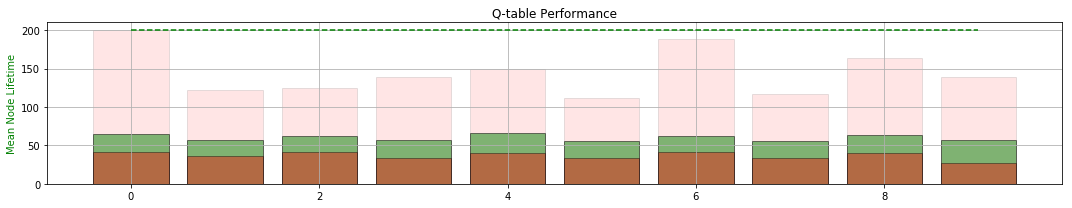

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.954	LOSS : 1.926	LOSS : 1.857	LOSS : 1.738	LOSS : 1.409	LOSS : 1.542	LOSS : 1.996	LOSS : 1.266	LOSS : 1.815	LOSS : 1.463	LOSS : 1.705	LOSS : 1.881	LOSS : 1.541	LOSS : 1.946	LOSS : 1.877	LOSS : 1.837	LOSS : 1.617	LOSS : 1.872	LOSS : 1.506	LOSS : 1.634	LOSS : 1.826	LOSS : 1.710	LOSS : 1.297	LOSS : 1.683	LOSS : 1.622	LOSS : 1.812	LOSS : 1.866	LOSS : 2.169	LOSS : 1.797	LOSS : 1.506	
Validating... MEAN TIME:  170.435
LOSS : 1.796	LOSS : 1.880	LOSS : 1.575	LOSS : 1.207	LOSS : 1.554	LOSS : 1.486	LOSS : 1.475	LOSS : 1.546	LOSS : 1.683	LOSS : 1.888	LOSS : 1.754	LOSS : 1.646	LOSS : 1.512	LOSS : 1.557	LOSS : 1.761	LOSS : 1.436	LOSS : 1.673	LOSS : 1.398	LOSS : 1.325	LOSS : 2.002	LOSS : 1.662	LOSS : 1.307	LOSS : 1.672	LOSS : 1.733	LOSS : 1.886	LOSS : 1.586	LOSS : 1.851	LOSS : 1.646	LOSS : 1.638	LOSS : 1.481	
Validating... MEAN TIME:  170.985
LOSS : 1.615	LOSS : 1

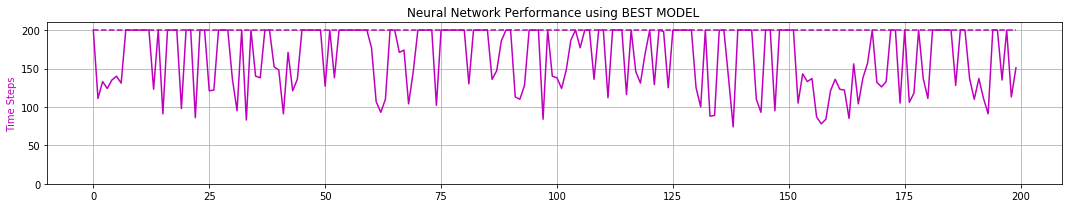

peak memory: 1428.21 MiB, increment: 1008.46 MiB
0 -max- [ 1.720  1.467  0.104  1.015]
0 -min- [-0.331 -1.113 -0.209 -0.741]

1 -max- [ 0.378  0.721  0.050  0.406]
1 -min- [-0.299 -0.960 -0.209 -1.092]

2 -max- [ 0.417  0.543  0.045  0.594]
2 -min- [-0.341 -0.963 -0.209 -0.745]

3 -max- [ 0.418  0.607  0.045  0.370]
3 -min- [-0.339 -0.947 -0.209 -1.101]

4 -max- [ 0.527  0.595  0.053  0.569]
4 -min- [-0.314 -0.959 -0.209 -0.730]

5 -max- [ 0.349  0.753  0.049  0.362]
5 -min- [-0.322 -0.956 -0.209 -1.061]

6 -max- [ 1.129  0.978  0.071  0.652]
6 -min- [-0.346 -1.234 -0.209 -0.711]

7 -max- [ 0.402  0.776  0.050  0.404]
7 -min- [-0.299 -0.956 -0.209 -1.033]

8 -max- [ 1.103  0.975  0.077  0.733]
8 -min- [-0.395 -1.146 -0.209 -0.746]

9 -max- [ 0.525  0.756  0.048  0.384]
9 -min- [-0.349 -1.080 -0.209 -0.972]

Quantization TIME:  0.01 minutes


ITERATION # 13
SMALLEST TIMESTEP in ITERATION 13: 32
REAL TIME TO GENERATE 57975 EXPERIENCES:0:00:01.431105


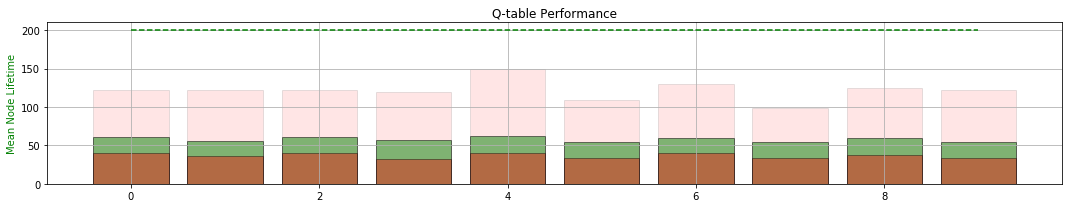

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.703	LOSS : 2.149	LOSS : 1.673	LOSS : 2.059	LOSS : 1.865	LOSS : 1.955	LOSS : 1.785	LOSS : 1.928	LOSS : 1.515	LOSS : 1.756	LOSS : 1.966	LOSS : 1.421	LOSS : 1.676	LOSS : 1.429	LOSS : 2.134	LOSS : 1.518	LOSS : 1.687	LOSS : 1.675	LOSS : 1.900	LOSS : 2.334	LOSS : 1.737	LOSS : 1.826	LOSS : 1.026	LOSS : 1.860	LOSS : 1.744	LOSS : 1.664	LOSS : 1.621	LOSS : 1.626	LOSS : 1.971	LOSS : 1.419	
Validating... MEAN TIME:  142.955
LOSS : 1.766	LOSS : 1.940	LOSS : 1.633	LOSS : 1.588	LOSS : 2.246	LOSS : 1.685	LOSS : 1.478	LOSS : 1.846	LOSS : 1.648	LOSS : 1.810	LOSS : 2.059	LOSS : 1.286	LOSS : 1.676	LOSS : 1.748	LOSS : 1.588	LOSS : 1.951	LOSS : 1.785	LOSS : 1.651	LOSS : 1.607	LOSS : 1.404	LOSS : 1.518	LOSS : 1.975	LOSS : 1.858	LOSS : 1.575	LOSS : 1.846	LOSS : 2.011	LOSS : 1.808	LOSS : 1.558	LOSS : 1.645	LOSS : 1.828	
Validating... MEAN TIME:  131.41
LOSS : 1.430	LOSS : 2.

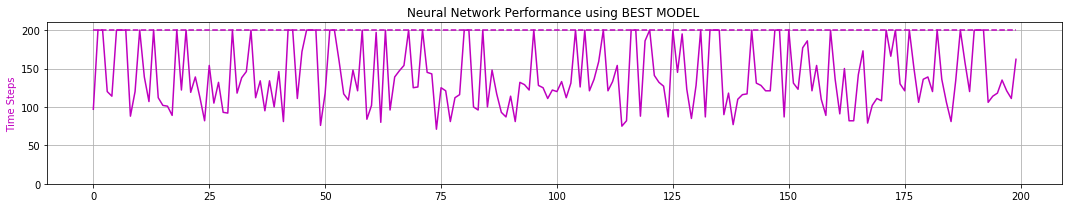

peak memory: 1387.04 MiB, increment: 974.52 MiB
0 -max- [ 0.212  0.427  0.057  0.588]
0 -min- [-0.664 -1.449 -0.209 -0.697]

1 -max- [ 0.202  0.550  0.045  0.190]
1 -min- [-0.355 -1.067 -0.209 -0.973]

2 -max- [ 0.200  0.425  0.045  0.542]
2 -min- [-0.404 -1.139 -0.209 -0.716]

3 -max- [ 0.240  0.632  0.050  0.201]
3 -min- [-0.402 -1.116 -0.209 -0.958]

4 -max- [ 0.243  0.433  0.050  0.638]
4 -min- [-0.486 -1.288 -0.209 -0.737]

5 -max- [ 0.205  0.620  0.050  0.204]
5 -min- [-0.301 -1.086 -0.209 -0.966]

6 -max- [ 0.306  0.523  0.070  0.652]
6 -min- [-0.424 -1.332 -0.209 -0.718]

7 -max- [ 0.195  0.750  0.050  0.218]
7 -min- [-0.308 -0.957 -0.209 -1.022]

8 -max- [ 0.195  0.427  0.048  0.642]
8 -min- [-0.454 -1.330 -0.209 -0.700]

9 -max- [ 0.182  0.447  0.049  0.211]
9 -min- [-0.392 -1.089 -0.209 -0.876]

Quantization TIME:  0.01 minutes


ITERATION # 14
SMALLEST TIMESTEP in ITERATION 14: 30
REAL TIME TO GENERATE 57350 EXPERIENCES:0:00:01.296096


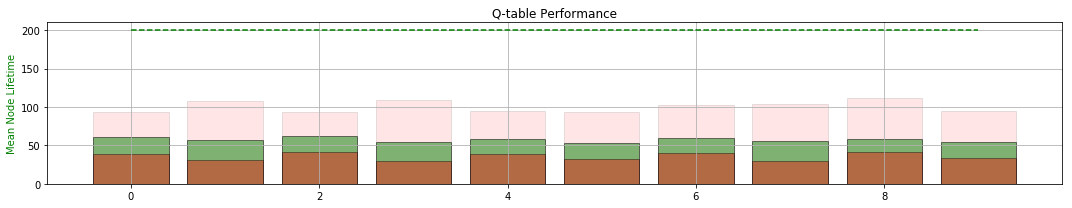

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.693	LOSS : 1.498	LOSS : 1.785	LOSS : 1.867	LOSS : 1.685	LOSS : 1.585	LOSS : 1.461	LOSS : 1.701	LOSS : 2.092	LOSS : 1.889	LOSS : 1.720	LOSS : 1.585	LOSS : 1.701	LOSS : 1.582	LOSS : 1.795	LOSS : 2.232	LOSS : 1.293	LOSS : 1.300	LOSS : 1.931	LOSS : 1.878	LOSS : 1.647	LOSS : 1.868	LOSS : 2.260	LOSS : 1.355	LOSS : 1.452	LOSS : 1.982	LOSS : 1.709	LOSS : 2.136	LOSS : 2.171	LOSS : 1.782	
Validating... MEAN TIME:  131.735
LOSS : 1.357	LOSS : 1.747	LOSS : 1.913	LOSS : 2.074	LOSS : 1.905	LOSS : 1.900	LOSS : 1.357	LOSS : 2.045	LOSS : 1.698	LOSS : 1.526	LOSS : 2.177	LOSS : 1.842	LOSS : 1.745	LOSS : 1.346	LOSS : 1.568	LOSS : 1.544	LOSS : 1.831	LOSS : 1.462	LOSS : 1.666	LOSS : 1.421	LOSS : 1.427	LOSS : 1.587	LOSS : 2.027	LOSS : 1.750	LOSS : 1.809	LOSS : 1.619	LOSS : 1.359	LOSS : 1.393	LOSS : 1.679	LOSS : 2.353	
Validating... MEAN TIME:  120.52
LOSS : 1.751	LOSS : 1.

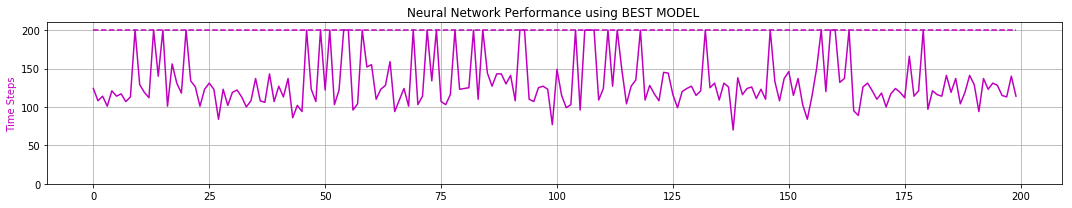

peak memory: 1449.75 MiB, increment: 977.75 MiB
0 -max- [ 0.223  0.434  0.045  0.869]
0 -min- [-0.368 -1.146 -0.209 -0.628]

1 -max- [ 0.195  0.549  0.045  0.195]
1 -min- [-0.337 -1.086 -0.209 -0.893]

2 -max- [ 0.205  0.433  0.050  0.621]
2 -min- [-0.534 -1.446 -0.209 -0.679]

3 -max- [ 0.201  0.435  0.049  0.188]
3 -min- [-0.302 -1.043 -0.209 -0.990]

4 -max- [ 0.219  0.435  0.050  0.621]
4 -min- [-0.412 -1.301 -0.209 -0.626]

5 -max- [ 0.223  0.810  0.050  0.199]
5 -min- [-0.357 -1.140 -0.209 -1.088]

6 -max- [ 0.439  0.551  0.074  0.643]
6 -min- [-0.410 -1.149 -0.209 -0.738]

7 -max- [ 0.195  0.771  0.048  0.194]
7 -min- [-0.321 -1.079 -0.209 -1.394]

8 -max- [ 0.198  0.412  0.051  0.423]
8 -min- [-0.508 -1.264 -0.209 -0.654]

9 -max- [ 0.190  0.572  0.051  0.178]
9 -min- [-0.355 -1.130 -0.209 -0.830]

Quantization TIME:  0.01 minutes


ITERATION # 15
SMALLEST TIMESTEP in ITERATION 15: 26
REAL TIME TO GENERATE 57948 EXPERIENCES:0:00:01.432964


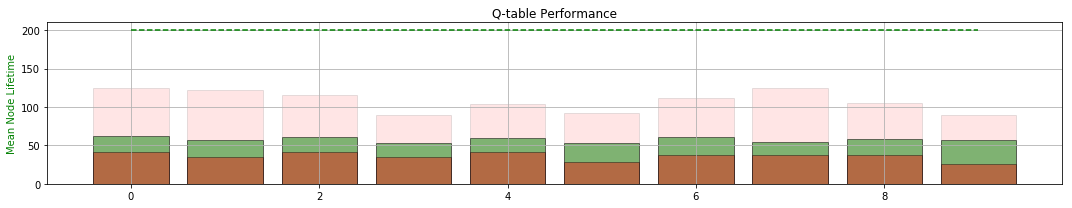

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.850	LOSS : 1.507	LOSS : 1.724	LOSS : 1.940	LOSS : 1.477	LOSS : 1.984	LOSS : 1.927	LOSS : 2.144	LOSS : 2.158	LOSS : 2.432	LOSS : 1.572	LOSS : 1.606	LOSS : 1.507	LOSS : 1.716	LOSS : 1.721	LOSS : 1.808	LOSS : 1.745	LOSS : 1.236	LOSS : 1.850	LOSS : 1.782	LOSS : 2.018	LOSS : 1.945	LOSS : 1.851	LOSS : 1.941	LOSS : 1.932	LOSS : 2.017	LOSS : 1.373	LOSS : 1.858	LOSS : 2.019	LOSS : 2.054	
Validating... MEAN TIME:  134.545
LOSS : 1.655	LOSS : 1.800	LOSS : 1.782	LOSS : 1.874	LOSS : 1.682	LOSS : 1.673	LOSS : 1.908	LOSS : 1.882	LOSS : 1.507	LOSS : 1.724	LOSS : 1.738	LOSS : 1.676	LOSS : 1.174	LOSS : 2.442	LOSS : 1.345	LOSS : 1.895	LOSS : 1.730	LOSS : 1.963	LOSS : 1.877	LOSS : 1.832	LOSS : 1.650	LOSS : 2.013	LOSS : 1.926	LOSS : 1.820	LOSS : 1.656	LOSS : 1.721	LOSS : 1.574	LOSS : 1.957	LOSS : 2.013	LOSS : 1.814	
Validating... MEAN TIME:  126.145
LOSS : 1.596	LOSS : 2

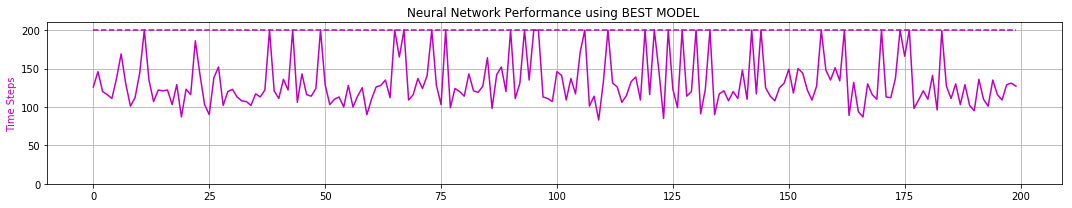

peak memory: 1455.59 MiB, increment: 973.22 MiB
0 -max- [ 0.195  0.422  0.045  0.636]
0 -min- [-0.515 -1.486 -0.209 -0.665]

1 -max- [ 0.225  0.628  0.050  0.184]
1 -min- [-0.402 -1.129 -0.209 -0.840]

2 -max- [ 0.206  0.433  0.049  0.513]
2 -min- [-0.495 -1.448 -0.209 -0.604]

3 -max- [ 0.205  0.629  0.050  0.188]
3 -min- [-0.372 -1.121 -0.209 -0.870]

4 -max- [ 0.251  0.537  0.069  0.652]
4 -min- [-0.519 -1.442 -0.209 -0.632]

5 -max- [ 0.173  0.635  0.050  0.189]
5 -min- [-0.359 -1.132 -0.209 -1.101]

6 -max- [ 0.205  0.428  0.048  0.654]
6 -min- [-0.755 -1.509 -0.209 -0.701]

7 -max- [ 0.162  0.630  0.049  0.211]
7 -min- [-0.392 -1.140 -0.209 -1.061]

8 -max- [ 0.190  0.429  0.051  0.464]
8 -min- [-0.471 -1.329 -0.209 -0.581]

9 -max- [ 0.207  0.601  0.050  0.144]
9 -min- [-0.294 -1.110 -0.209 -1.069]

Quantization TIME:  0.01 minutes


ITERATION # 16
SMALLEST TIMESTEP in ITERATION 16: 31
REAL TIME TO GENERATE 57374 EXPERIENCES:0:00:01.326186


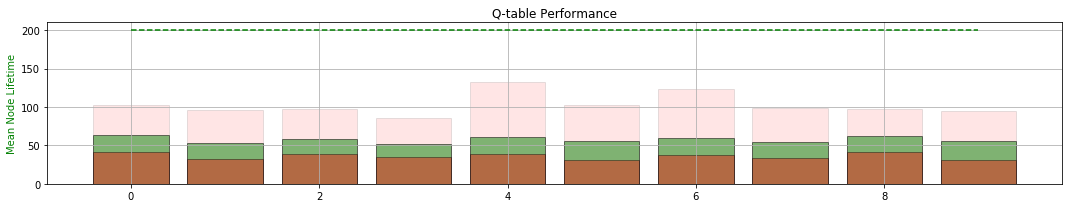

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.918	LOSS : 1.957	LOSS : 1.808	LOSS : 1.766	LOSS : 1.878	LOSS : 1.916	LOSS : 1.981	LOSS : 2.135	LOSS : 1.688	LOSS : 1.801	LOSS : 2.076	LOSS : 1.890	LOSS : 2.030	LOSS : 2.116	LOSS : 2.126	LOSS : 1.887	LOSS : 2.236	LOSS : 1.955	LOSS : 1.857	LOSS : 1.696	LOSS : 1.496	LOSS : 1.791	LOSS : 1.765	LOSS : 2.598	LOSS : 2.045	LOSS : 2.039	LOSS : 1.912	LOSS : 1.847	LOSS : 1.787	LOSS : 1.827	
Validating... MEAN TIME:  117.285
LOSS : 2.000	LOSS : 2.057	LOSS : 1.728	LOSS : 1.612	LOSS : 1.940	LOSS : 2.056	LOSS : 1.870	LOSS : 1.532	LOSS : 1.605	LOSS : 1.525	LOSS : 1.766	LOSS : 1.769	LOSS : 2.192	LOSS : 1.572	LOSS : 2.015	LOSS : 1.886	LOSS : 2.457	LOSS : 1.992	LOSS : 1.563	LOSS : 1.842	LOSS : 2.483	LOSS : 1.608	LOSS : 1.735	LOSS : 1.921	LOSS : 1.819	LOSS : 1.958	LOSS : 1.591	LOSS : 1.732	LOSS : 2.030	LOSS : 1.923	
Validating... MEAN TIME:  111.13
LOSS : 1.783	LOSS : 1.

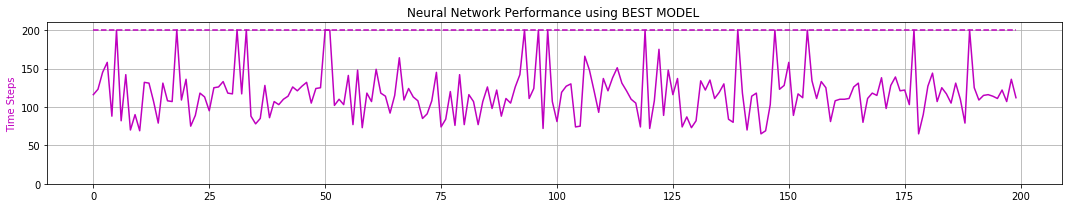

peak memory: 1414.00 MiB, increment: 1015.58 MiB
0 -max- [ 0.215  0.433  0.054  0.566]
0 -min- [-0.502 -1.320 -0.209 -0.764]

1 -max- [ 0.205  0.625  0.049  0.190]
1 -min- [-0.411 -1.312 -0.209 -1.140]

2 -max- [ 0.219  0.434  0.050  0.617]
2 -min- [-0.584 -1.458 -0.209 -0.715]

3 -max- [ 0.215  0.813  0.050  0.255]
3 -min- [-0.474 -1.330 -0.209 -0.991]

4 -max- [ 0.195  0.425  0.050  0.615]
4 -min- [-0.558 -1.332 -0.209 -0.715]

5 -max- [ 0.199  0.600  0.048  0.235]
5 -min- [-0.479 -1.330 -0.209 -1.353]

6 -max- [ 0.208  0.412  0.054  0.710]
6 -min- [-0.564 -1.484 -0.209 -0.695]

7 -max- [ 0.190  0.633  0.051  0.235]
7 -min- [-0.463 -1.310 -0.209 -0.986]

8 -max- [ 0.207  0.427  0.050  0.509]
8 -min- [-0.515 -1.322 -0.209 -0.707]

9 -max- [ 0.237  0.619  0.049  0.250]
9 -min- [-0.497 -1.327 -0.209 -1.211]

Quantization TIME:  0.01 minutes


ITERATION # 17
SMALLEST TIMESTEP in ITERATION 17: 27
REAL TIME TO GENERATE 57599 EXPERIENCES:0:00:01.400252


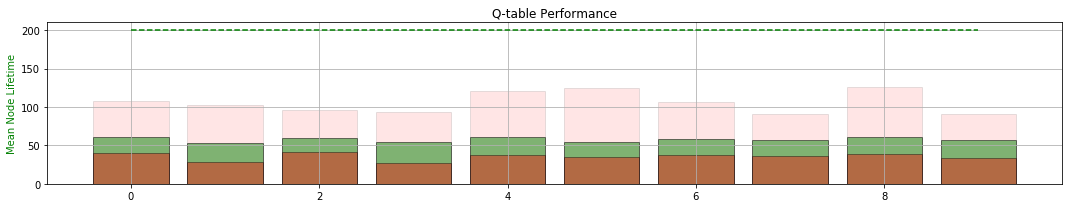

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.871	LOSS : 1.694	LOSS : 1.704	LOSS : 1.553	LOSS : 1.788	LOSS : 1.870	LOSS : 1.907	LOSS : 1.510	LOSS : 2.087	LOSS : 1.835	LOSS : 1.703	LOSS : 1.504	LOSS : 1.892	LOSS : 1.876	LOSS : 1.884	LOSS : 1.880	LOSS : 2.124	LOSS : 1.906	LOSS : 2.233	LOSS : 1.760	LOSS : 1.817	LOSS : 2.041	LOSS : 2.152	LOSS : 2.267	LOSS : 1.803	LOSS : 1.811	LOSS : 1.646	LOSS : 1.706	LOSS : 1.686	LOSS : 1.999	
Validating... MEAN TIME:  100.59
LOSS : 1.839	LOSS : 1.829	LOSS : 1.988	LOSS : 1.675	LOSS : 2.044	LOSS : 1.820	LOSS : 1.686	LOSS : 1.653	LOSS : 1.643	LOSS : 1.408	LOSS : 2.081	LOSS : 1.791	LOSS : 2.315	LOSS : 1.687	LOSS : 1.857	LOSS : 1.953	LOSS : 1.831	LOSS : 1.969	LOSS : 1.920	LOSS : 1.728	LOSS : 1.715	LOSS : 1.701	LOSS : 1.919	LOSS : 1.632	LOSS : 1.927	LOSS : 2.001	LOSS : 2.114	LOSS : 1.951	LOSS : 1.629	LOSS : 1.905	
Validating... MEAN TIME:  96.38
LOSS : 1.907	LOSS : 2.17

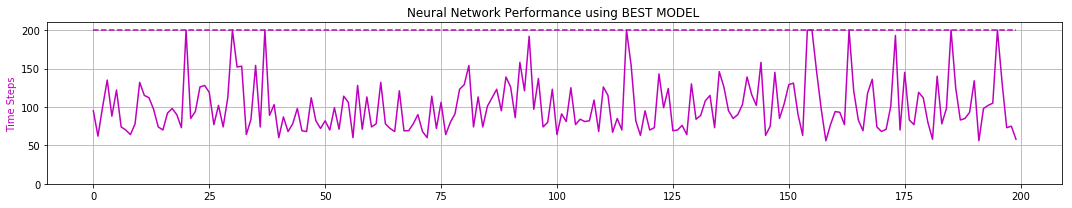

peak memory: 1453.06 MiB, increment: 1016.46 MiB
0 -max- [ 0.197  0.574  0.049  0.618]
0 -min- [-0.415 -1.302 -0.209 -0.685]

1 -max- [ 0.205  0.548  0.050  0.188]
1 -min- [-0.412 -1.107 -0.209 -0.943]

2 -max- [ 0.545  0.720  0.077  0.727]
2 -min- [-0.437 -1.300 -0.209 -0.771]

3 -max- [ 0.195  0.622  0.050  0.189]
3 -min- [-0.308 -1.101 -0.209 -0.995]

4 -max- [ 0.195  0.417  0.048  0.642]
4 -min- [-0.540 -1.320 -0.209 -0.704]

5 -max- [ 0.185  0.548  0.049  0.219]
5 -min- [-0.392 -1.140 -0.209 -0.833]

6 -max- [ 0.220  0.429  0.055  0.432]
6 -min- [-0.456 -1.283 -0.209 -0.691]

7 -max- [ 0.202  0.621  0.050  0.143]
7 -min- [-0.350 -1.116 -0.209 -0.880]

8 -max- [ 0.247  0.435  0.049  0.436]
8 -min- [-0.554 -1.317 -0.209 -0.726]

9 -max- [ 0.216  0.620  0.050  0.146]
9 -min- [-0.312 -1.103 -0.209 -1.052]

Quantization TIME:  0.01 minutes


ITERATION # 18
SMALLEST TIMESTEP in ITERATION 18: 27
REAL TIME TO GENERATE 55609 EXPERIENCES:0:00:01.349175


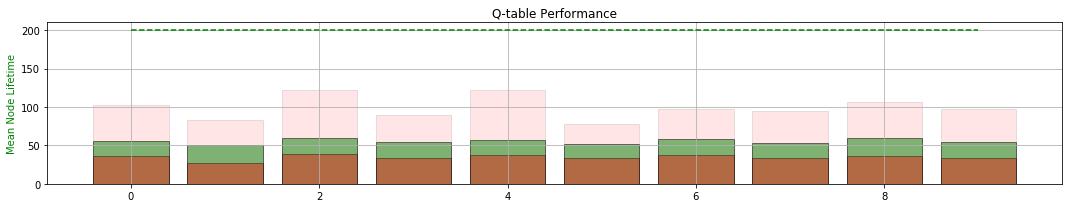

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.792	LOSS : 1.624	LOSS : 1.836	LOSS : 1.935	LOSS : 1.581	LOSS : 1.823	LOSS : 1.963	LOSS : 1.887	LOSS : 1.990	LOSS : 2.119	LOSS : 2.020	LOSS : 2.279	LOSS : 1.789	LOSS : 1.767	LOSS : 1.844	LOSS : 2.282	LOSS : 1.757	LOSS : 1.754	LOSS : 1.885	LOSS : 1.882	LOSS : 2.097	LOSS : 2.330	LOSS : 2.396	LOSS : 1.938	LOSS : 2.122	LOSS : 2.017	LOSS : 1.998	LOSS : 1.878	LOSS : 2.028	LOSS : 1.996	
Validating... MEAN TIME:  93.48
LOSS : 1.753	LOSS : 2.089	LOSS : 1.626	LOSS : 1.779	LOSS : 1.728	LOSS : 2.252	LOSS : 2.106	LOSS : 1.910	LOSS : 1.486	LOSS : 1.346	LOSS : 2.110	LOSS : 1.903	LOSS : 2.033	LOSS : 1.666	LOSS : 1.725	LOSS : 1.862	LOSS : 1.660	LOSS : 1.623	LOSS : 1.774	LOSS : 1.847	LOSS : 2.024	LOSS : 2.483	LOSS : 2.322	LOSS : 2.052	LOSS : 1.560	LOSS : 1.892	LOSS : 1.934	LOSS : 1.944	LOSS : 1.757	LOSS : 1.823	
Validating... MEAN TIME:  101.565
LOSS : 1.793	LOSS : 1.9

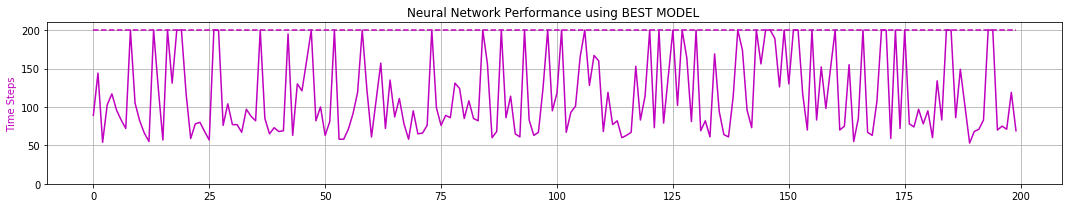

peak memory: 1373.70 MiB, increment: 993.11 MiB
0 -max- [ 0.219  0.571  0.050  0.652]
0 -min- [-0.529 -1.282 -0.209 -0.759]

1 -max- [ 0.203  0.626  0.050  0.143]
1 -min- [-0.357 -1.140 -0.209 -1.178]

2 -max- [ 0.360  0.561  0.074  0.643]
2 -min- [-0.539 -1.451 -0.209 -0.729]

3 -max- [ 0.168  0.615  0.048  0.200]
3 -min- [-0.354 -1.139 -0.209 -0.978]

4 -max- [ 0.187  0.412  0.049  0.495]
4 -min- [-0.471 -1.324 -0.209 -0.726]

5 -max- [ 0.190  0.598  0.051  0.176]
5 -min- [-0.355 -1.130 -0.209 -0.919]

6 -max- [ 0.267  0.572  0.054  0.423]
6 -min- [-0.321 -1.072 -0.209 -0.696]

7 -max- [ 0.237  0.752  0.049  0.171]
7 -min- [-0.361 -1.113 -0.209 -1.006]

8 -max- [ 0.220  0.579  0.050  0.583]
8 -min- [-0.472 -1.310 -0.209 -0.743]

9 -max- [ 0.195  0.820  0.050  0.166]
9 -min- [-0.398 -1.080 -0.209 -1.187]

Quantization TIME:  0.01 minutes


ITERATION # 19
SMALLEST TIMESTEP in ITERATION 19: 32
REAL TIME TO GENERATE 54302 EXPERIENCES:0:00:01.299208


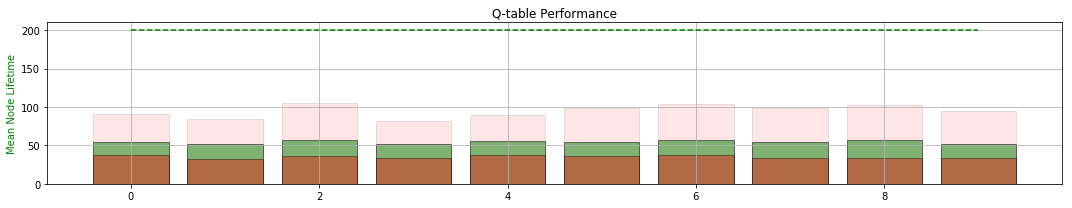

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.612	LOSS : 1.870	LOSS : 2.173	LOSS : 2.006	LOSS : 1.884	LOSS : 1.801	LOSS : 1.552	LOSS : 1.742	LOSS : 1.771	LOSS : 2.054	LOSS : 1.860	LOSS : 1.765	LOSS : 1.842	LOSS : 1.647	LOSS : 2.159	LOSS : 1.952	LOSS : 1.845	LOSS : 2.290	LOSS : 1.807	LOSS : 2.050	LOSS : 1.541	LOSS : 1.818	LOSS : 2.053	LOSS : 2.310	LOSS : 1.915	LOSS : 1.770	LOSS : 1.352	LOSS : 2.247	LOSS : 2.345	LOSS : 1.672	
Validating... MEAN TIME:  128.95
LOSS : 1.757	LOSS : 1.610	LOSS : 2.109	LOSS : 1.551	LOSS : 2.001	LOSS : 2.277	LOSS : 1.614	LOSS : 1.836	LOSS : 2.067	LOSS : 2.204	LOSS : 1.727	LOSS : 1.645	LOSS : 2.641	LOSS : 1.915	LOSS : 2.123	LOSS : 1.739	LOSS : 1.732	LOSS : 1.779	LOSS : 1.690	LOSS : 1.953	LOSS : 2.009	LOSS : 1.923	LOSS : 1.652	LOSS : 1.943	LOSS : 2.088	LOSS : 1.975	LOSS : 1.896	LOSS : 1.230	LOSS : 1.871	LOSS : 1.900	
Validating... MEAN TIME:  132.795
LOSS : 2.032	LOSS : 1.

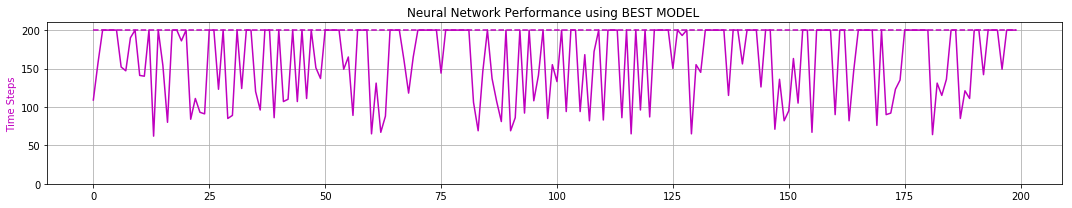

peak memory: 1414.66 MiB, increment: 1035.29 MiB
0 -max- [ 0.175  0.573  0.052  0.617]
0 -min- [-0.385 -1.089 -0.209 -0.751]

1 -max- [ 0.150  0.602  0.050  0.312]
1 -min- [-0.281 -0.956 -0.209 -1.105]

2 -max- [ 0.163  0.432  0.048  0.642]
2 -min- [-0.366 -1.155 -0.209 -0.761]

3 -max- [ 0.140  0.598  0.049  0.211]
3 -min- [-0.306 -0.874 -0.209 -0.994]

4 -max- [ 0.167  0.616  0.051  0.534]
4 -min- [-0.310 -0.967 -0.209 -0.712]

5 -max- [ 0.166  0.613  0.050  0.139]
5 -min- [-0.269 -0.948 -0.209 -0.969]

6 -max- [ 0.181  0.577  0.049  0.419]
6 -min- [-0.395 -1.088 -0.209 -0.764]

7 -max- [ 0.156  0.632  0.050  0.193]
7 -min- [-0.277 -0.928 -0.209 -1.052]

8 -max- [ 0.167  0.579  0.067  0.864]
8 -min- [-0.381 -1.084 -0.209 -0.729]

9 -max- [ 0.163  0.762  0.049  0.171]
9 -min- [-0.280 -0.946 -0.209 -1.106]

Quantization TIME:  0.01 minutes


ITERATION # 20
SMALLEST TIMESTEP in ITERATION 20: 27
REAL TIME TO GENERATE 55331 EXPERIENCES:0:00:01.410657


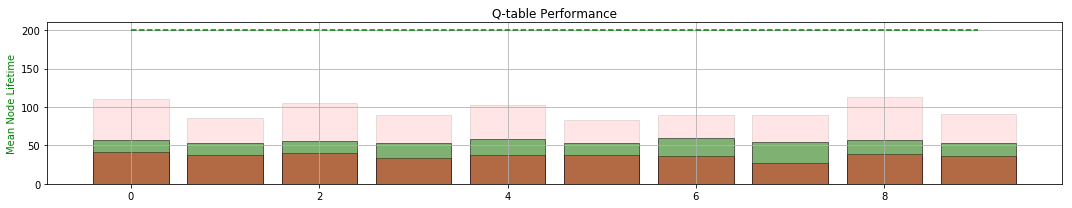

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.650	LOSS : 1.829	LOSS : 1.638	LOSS : 1.609	LOSS : 1.667	LOSS : 1.789	LOSS : 1.868	LOSS : 1.878	LOSS : 1.744	LOSS : 2.110	LOSS : 1.700	LOSS : 2.095	LOSS : 1.967	LOSS : 2.177	LOSS : 1.849	LOSS : 2.145	LOSS : 2.176	LOSS : 2.140	LOSS : 1.817	LOSS : 1.912	LOSS : 1.770	LOSS : 1.659	LOSS : 1.645	LOSS : 1.800	LOSS : 2.358	LOSS : 2.124	LOSS : 1.809	LOSS : 2.133	LOSS : 1.943	LOSS : 1.541	
Validating... MEAN TIME:  181.375
LOSS : 1.429	LOSS : 1.915	LOSS : 1.761	LOSS : 2.108	LOSS : 1.840	LOSS : 2.196	LOSS : 1.848	LOSS : 1.802	LOSS : 1.715	LOSS : 1.368	LOSS : 1.956	LOSS : 1.949	LOSS : 1.955	LOSS : 1.955	LOSS : 1.831	LOSS : 1.665	LOSS : 2.075	LOSS : 1.673	LOSS : 1.337	LOSS : 1.922	LOSS : 2.177	LOSS : 1.729	LOSS : 1.596	LOSS : 1.587	LOSS : 1.668	LOSS : 1.832	LOSS : 1.840	LOSS : 1.838	LOSS : 1.897	LOSS : 1.952	
Validating... MEAN TIME:  178.45
LOSS : 2.023	LOSS : 1.

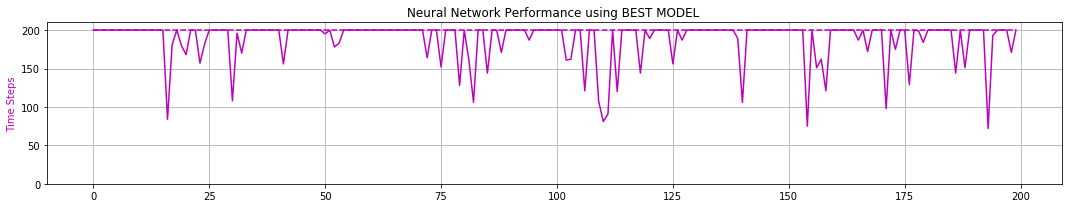

peak memory: 1433.09 MiB, increment: 1016.85 MiB
0 -max- [ 0.155  0.595  0.051  0.555]
0 -min- [-0.367 -1.084 -0.209 -0.768]

1 -max- [ 0.182  0.828  0.048  0.369]
1 -min- [-0.300 -0.952 -0.209 -1.208]

2 -max- [ 0.140  0.564  0.049  0.620]
2 -min- [-0.477 -1.062 -0.209 -0.774]

3 -max- [ 0.170  0.624  0.051  0.224]
3 -min- [-0.272 -0.946 -0.209 -0.921]

4 -max- [ 0.183  0.613  0.054  0.460]
4 -min- [-0.287 -1.053 -0.209 -0.808]

5 -max- [ 0.185  0.621  0.049  0.307]
5 -min- [-0.265 -0.947 -0.209 -1.050]

6 -max- [ 0.177  0.618  0.050  0.655]
6 -min- [-0.292 -0.953 -0.209 -0.753]

7 -max- [ 0.167  0.606  0.050  0.297]
7 -min- [-0.255 -0.947 -0.209 -1.327]

8 -max- [ 0.171  0.620  0.049  0.646]
8 -min- [-0.295 -0.960 -0.209 -0.746]

9 -max- [ 0.191  0.627  0.048  0.297]
9 -min- [-0.274 -0.952 -0.209 -1.047]

Quantization TIME:  0.01 minutes


ITERATION # 21
SMALLEST TIMESTEP in ITERATION 21: 30
REAL TIME TO GENERATE 61307 EXPERIENCES:0:00:01.443838


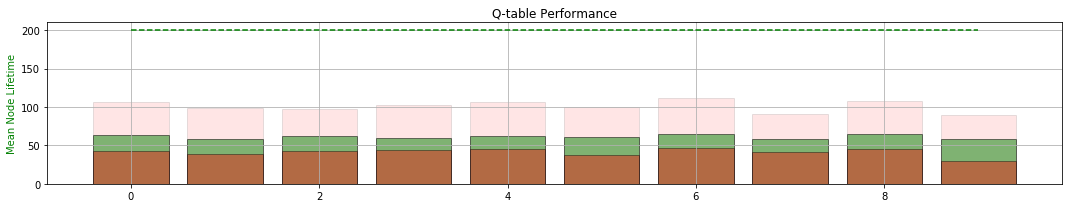

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.604	LOSS : 1.586	LOSS : 1.955	LOSS : 2.143	LOSS : 1.640	LOSS : 2.168	LOSS : 2.133	LOSS : 1.676	LOSS : 1.754	LOSS : 1.822	LOSS : 1.581	LOSS : 1.995	LOSS : 2.040	LOSS : 1.820	LOSS : 1.832	LOSS : 1.834	LOSS : 2.143	LOSS : 2.064	LOSS : 1.998	LOSS : 1.418	LOSS : 1.921	LOSS : 1.828	LOSS : 1.684	LOSS : 1.733	LOSS : 1.952	LOSS : 1.489	LOSS : 2.436	LOSS : 2.227	LOSS : 1.743	LOSS : 1.644	
Validating... MEAN TIME:  191.53
LOSS : 1.875	LOSS : 1.846	LOSS : 1.941	LOSS : 1.989	LOSS : 2.119	LOSS : 1.935	LOSS : 2.103	LOSS : 1.850	LOSS : 1.582	LOSS : 1.797	LOSS : 1.794	LOSS : 1.855	LOSS : 2.112	LOSS : 2.256	LOSS : 1.640	LOSS : 1.814	LOSS : 2.114	LOSS : 1.894	LOSS : 1.638	LOSS : 2.039	LOSS : 2.062	LOSS : 1.940	LOSS : 1.884	LOSS : 2.002	LOSS : 1.925	LOSS : 1.652	LOSS : 1.805	LOSS : 1.809	LOSS : 1.826	LOSS : 1.868	
Validating... MEAN TIME:  190.015
LOSS : 1.776	LOSS : 2.

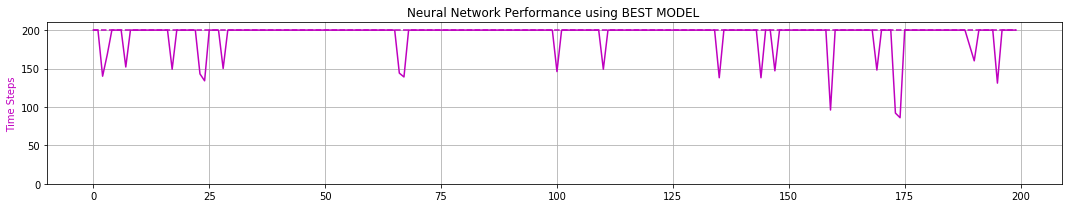

peak memory: 1324.24 MiB, increment: 940.72 MiB
0 -max- [ 0.152  0.574  0.048  0.642]
0 -min- [-0.672 -1.448 -0.209 -0.793]

1 -max- [ 0.140  0.595  0.049  0.377]
1 -min- [-0.449 -1.089 -0.209 -1.006]

2 -max- [ 0.165  0.616  0.051  0.527]
2 -min- [-0.499 -1.268 -0.209 -0.757]

3 -max- [ 0.174  0.613  0.050  0.379]
3 -min- [-0.405 -1.088 -0.209 -0.905]

4 -max- [ 0.179  0.620  0.049  0.571]
4 -min- [-0.492 -1.271 -0.209 -0.804]

5 -max- [ 0.167  0.618  0.050  0.398]
5 -min- [-0.417 -1.088 -0.209 -0.981]

6 -max- [ 0.178  0.605  0.050  0.622]
6 -min- [-0.529 -1.258 -0.209 -0.735]

7 -max- [ 0.177  0.585  0.049  0.384]
7 -min- [-0.488 -1.259 -0.209 -1.062]

8 -max- [ 0.191  0.625  0.048  0.635]
8 -min- [-0.553 -1.451 -0.209 -0.750]

9 -max- [ 0.175  0.629  0.048  0.392]
9 -min- [-0.421 -1.088 -0.209 -0.994]

Quantization TIME:  0.01 minutes


ITERATION # 22
SMALLEST TIMESTEP in ITERATION 22: 41
REAL TIME TO GENERATE 115703 EXPERIENCES:0:00:02.862696


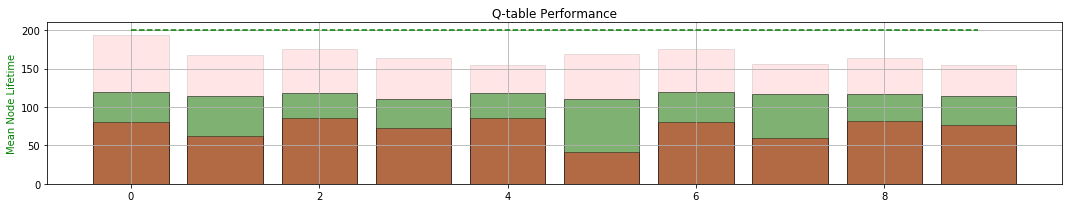

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.511	LOSS : 2.053	LOSS : 2.518	LOSS : 2.155	LOSS : 2.499	LOSS : 2.491	LOSS : 2.081	LOSS : 2.188	LOSS : 2.220	LOSS : 2.263	LOSS : 2.797	LOSS : 2.156	LOSS : 2.245	LOSS : 2.155	LOSS : 2.327	LOSS : 2.478	LOSS : 2.491	LOSS : 2.576	LOSS : 2.343	LOSS : 2.270	LOSS : 2.206	LOSS : 2.185	LOSS : 2.457	LOSS : 2.110	LOSS : 2.164	LOSS : 2.133	LOSS : 2.377	LOSS : 2.325	LOSS : 2.107	LOSS : 2.306	
Validating... MEAN TIME:  158.405
LOSS : 2.391	LOSS : 2.092	LOSS : 2.411	LOSS : 2.396	LOSS : 1.889	LOSS : 2.348	LOSS : 2.367	LOSS : 2.314	LOSS : 2.265	LOSS : 2.133	LOSS : 2.240	LOSS : 2.053	LOSS : 2.189	LOSS : 2.162	LOSS : 2.341	LOSS : 2.216	LOSS : 2.150	LOSS : 2.284	LOSS : 2.238	LOSS : 2.388	LOSS : 2.342	LOSS : 2.414	LOSS : 2.373	LOSS : 2.319	LOSS : 2.168	LOSS : 2.596	LOSS : 2.322	LOSS : 2.253	LOSS : 2.747	LOSS : 2.189	
Validating... MEAN TIME:  66.71
LOSS : 2.409	LOSS : 1.8

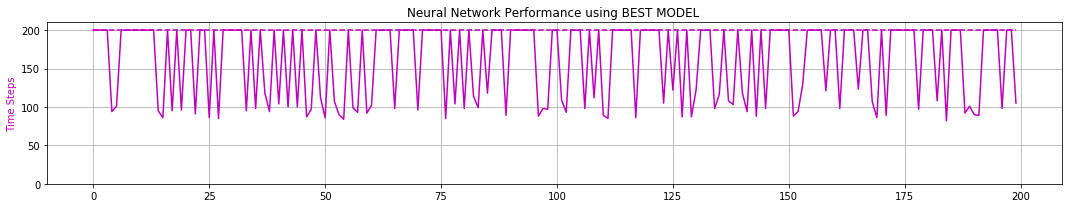

peak memory: 1421.59 MiB, increment: 1034.73 MiB
0 -max- [ 1.025  2.241  0.209  1.770]
0 -min- [-2.398 -3.310 -0.209 -1.241]

1 -max- [ 0.197  0.614  0.209  1.682]
1 -min- [-2.397 -3.346 -0.209 -1.151]

2 -max- [ 0.187  0.622  0.208  1.743]
2 -min- [-2.398 -3.299 -0.209 -0.744]

3 -max- [ 0.222  0.628  0.209  1.554]
3 -min- [-2.399 -3.313 -0.209 -0.961]

4 -max- [ 0.203  0.628  0.209  1.887]
4 -min- [-2.398 -3.148 -0.209 -0.749]

5 -max- [ 0.211  0.743  0.209  1.753]
5 -min- [-2.400 -3.349 -0.209 -1.288]

6 -max- [ 0.908  1.904  0.209  1.706]
6 -min- [-2.400 -3.497 -0.209 -1.100]

7 -max- [ 0.984  2.416  0.209  1.755]
7 -min- [-2.396 -3.350 -0.209 -1.391]

8 -max- [ 0.194  0.623  0.209  1.772]
8 -min- [-2.400 -3.317 -0.208 -0.729]

9 -max- [ 0.212  0.628  0.209  1.702]
9 -min- [-2.400 -3.335 -0.209 -0.920]

Quantization TIME:  0.01 minutes


ITERATION # 23
SMALLEST TIMESTEP in ITERATION 23: 99
REAL TIME TO GENERATE 193958 EXPERIENCES:0:00:06.170613


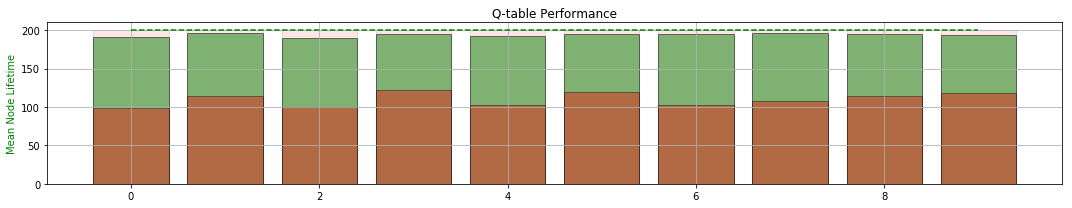

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.275	LOSS : 1.638	LOSS : 1.126	LOSS : 1.219	LOSS : 1.334	LOSS : 1.551	LOSS : 1.556	LOSS : 1.321	LOSS : 1.383	LOSS : 1.494	LOSS : 1.516	LOSS : 1.557	LOSS : 1.578	LOSS : 1.304	LOSS : 1.452	LOSS : 1.414	LOSS : 1.524	LOSS : 1.448	LOSS : 1.304	LOSS : 1.526	LOSS : 1.461	LOSS : 1.209	LOSS : 1.398	LOSS : 1.635	LOSS : 1.271	LOSS : 1.213	LOSS : 1.285	LOSS : 1.330	LOSS : 1.252	LOSS : 1.375	
Validating... MEAN TIME:  9.395
LOSS : 1.305	LOSS : 1.453	LOSS : 1.240	LOSS : 1.486	LOSS : 1.362	LOSS : 1.165	LOSS : 1.349	LOSS : 1.379	LOSS : 1.284	LOSS : 1.118	LOSS : 1.439	LOSS : 1.547	LOSS : 1.407	LOSS : 1.380	LOSS : 1.213	LOSS : 1.281	LOSS : 1.496	LOSS : 1.330	LOSS : 1.290	LOSS : 1.303	LOSS : 1.084	LOSS : 1.207	LOSS : 1.199	LOSS : 1.348	LOSS : 1.243	LOSS : 1.379	LOSS : 1.217	LOSS : 1.577	LOSS : 1.453	LOSS : 1.091	
Validating... MEAN TIME:  9.395
LOSS : 1.283	LOSS : 1.407

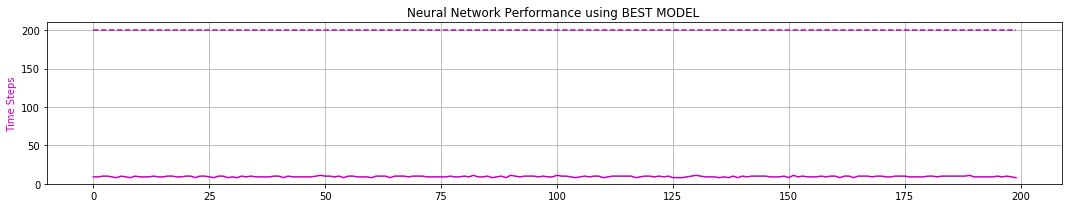

peak memory: 1477.32 MiB, increment: 1049.36 MiB
0 -max- [ 1.109  1.833  0.200  2.075]
0 -min- [-1.848 -3.140 -0.209 -1.094]

1 -max- [ 1.048  1.824  0.209  2.053]
1 -min- [-2.008 -3.209 -0.208 -1.069]

2 -max- [ 0.954  1.331  0.209  2.092]
2 -min- [-2.092 -3.397 -0.209 -0.912]

3 -max- [ 1.037  1.837  0.208  1.833]
3 -min- [-2.330 -3.562 -0.209 -1.133]

4 -max- [ 0.998  1.498  0.208  2.086]
4 -min- [-2.179 -3.219 -0.209 -0.982]

5 -max- [ 0.831  1.301  0.208  2.033]
5 -min- [-2.368 -3.537 -0.209 -1.083]

6 -max- [ 0.962  1.467  0.206  2.101]
6 -min- [-1.934 -3.205 -0.208 -0.960]

7 -max- [ 1.135  2.035  0.208  2.397]
7 -min- [-2.253 -3.772 -0.208 -1.303]

8 -max- [ 0.943  1.346  0.209  2.038]
8 -min- [-1.949 -3.212 -0.209 -0.926]

9 -max- [ 1.040  1.887  0.205  2.015]
9 -min- [-2.257 -3.527 -0.209 -1.097]

Quantization TIME:  0.01 minutes


ITERATION # 24
SMALLEST TIMESTEP in ITERATION 24: 8
REAL TIME TO GENERATE 9543 EXPERIENCES:0:00:00.355551


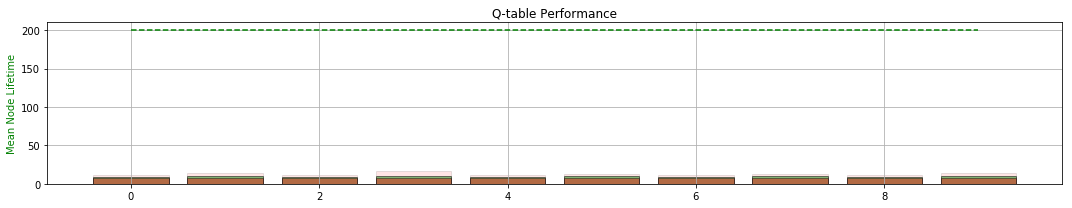

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.525	LOSS : 1.148	LOSS : 1.238	LOSS : 1.617	LOSS : 1.261	LOSS : 1.401	LOSS : 1.483	LOSS : 1.479	LOSS : 1.438	LOSS : 1.746	LOSS : 1.272	LOSS : 1.303	LOSS : 1.510	LOSS : 1.533	LOSS : 1.412	LOSS : 1.296	LOSS : 1.330	LOSS : 1.326	LOSS : 1.226	LOSS : 1.281	LOSS : 1.314	LOSS : 1.469	LOSS : 1.635	LOSS : 1.226	LOSS : 1.219	LOSS : 1.380	LOSS : 1.416	LOSS : 1.304	LOSS : 1.212	LOSS : 1.378	
Validating... MEAN TIME:  9.38
LOSS : 1.667	LOSS : 1.221	LOSS : 1.201	LOSS : 1.351	LOSS : 1.417	LOSS : 1.539	LOSS : 1.291	LOSS : 1.371	LOSS : 1.462	LOSS : 1.256	LOSS : 1.273	LOSS : 1.311	LOSS : 1.294	LOSS : 1.122	LOSS : 1.443	LOSS : 1.465	LOSS : 1.236	LOSS : 1.372	LOSS : 1.253	LOSS : 1.035	LOSS : 1.081	LOSS : 1.237	LOSS : 1.662	LOSS : 1.219	LOSS : 1.127	LOSS : 1.134	LOSS : 1.324	LOSS : 1.305	LOSS : 1.482	LOSS : 1.097	
Validating... MEAN TIME:  9.295
LOSS : 1.245	LOSS : 1.482	

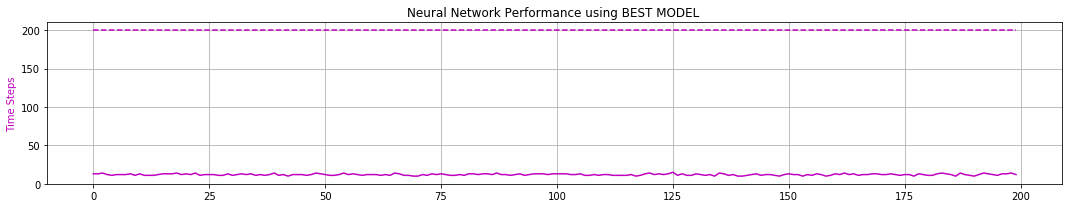

peak memory: 1397.73 MiB, increment: 1016.87 MiB
0 -max- [ 0.048  0.049  0.208  2.960]
0 -min- [-0.197 -1.929 -0.048 -0.048]

1 -max- [ 0.048  0.192  0.209  2.948]
1 -min- [-0.210 -1.985 -0.050 -0.349]

2 -max- [ 0.051  0.050  0.209  2.964]
2 -min- [-0.191 -1.998 -0.049 -0.050]

3 -max- [ 0.050  0.387  0.209  2.952]
3 -min- [-0.213 -1.981 -0.067 -0.575]

4 -max- [ 0.050  0.049  0.209  2.968]
4 -min- [-0.220 -1.983 -0.047 -0.048]

5 -max- [ 0.049  0.218  0.209  2.962]
5 -min- [-0.218 -1.961 -0.050 -0.318]

6 -max- [ 0.049  0.049  0.209  2.981]
6 -min- [-0.223 -1.988 -0.050 -0.049]

7 -max- [ 0.050  0.375  0.209  2.939]
7 -min- [-0.184 -1.946 -0.050 -0.584]

8 -max- [ 0.048  0.050  0.209  2.962]
8 -min- [-0.221 -1.948 -0.049 -0.049]

9 -max- [ 0.050  0.232  0.209  2.942]
9 -min- [-0.222 -2.001 -0.047 -0.336]

Quantization TIME:  0.01 minutes


ITERATION # 25
SMALLEST TIMESTEP in ITERATION 25: 11
REAL TIME TO GENERATE 47655 EXPERIENCES:0:00:01.227097


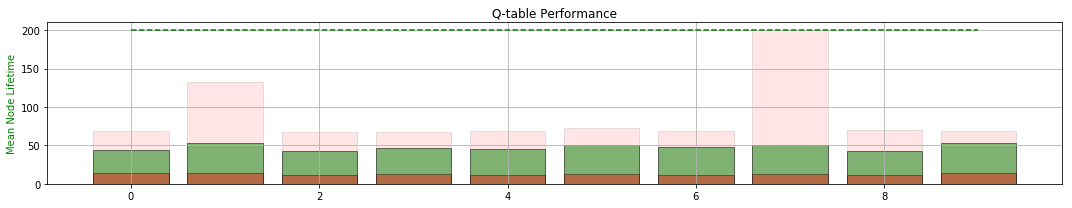

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.238	LOSS : 1.210	LOSS : 1.695	LOSS : 1.446	LOSS : 1.460	LOSS : 1.537	LOSS : 1.565	LOSS : 0.916	LOSS : 1.309	LOSS : 1.222	LOSS : 1.546	LOSS : 1.498	LOSS : 1.397	LOSS : 1.589	LOSS : 1.267	LOSS : 1.418	LOSS : 1.600	LOSS : 0.962	LOSS : 1.219	LOSS : 1.401	LOSS : 1.271	LOSS : 1.735	LOSS : 1.156	LOSS : 1.275	LOSS : 1.520	LOSS : 1.212	LOSS : 1.140	LOSS : 1.370	LOSS : 1.375	LOSS : 1.301	
Validating... MEAN TIME:  12.985
LOSS : 1.371	LOSS : 1.517	LOSS : 0.994	LOSS : 1.571	LOSS : 1.362	LOSS : 1.157	LOSS : 1.302	LOSS : 1.156	LOSS : 1.753	LOSS : 1.183	LOSS : 1.173	LOSS : 1.199	LOSS : 1.211	LOSS : 1.119	LOSS : 1.101	LOSS : 1.065	LOSS : 1.088	LOSS : 1.395	LOSS : 1.443	LOSS : 1.371	LOSS : 1.286	LOSS : 1.259	LOSS : 0.963	LOSS : 1.093	LOSS : 1.303	LOSS : 1.076	LOSS : 1.255	LOSS : 1.369	LOSS : 1.548	LOSS : 1.345	
Validating... MEAN TIME:  17.705
LOSS : 1.311	LOSS : 1.1

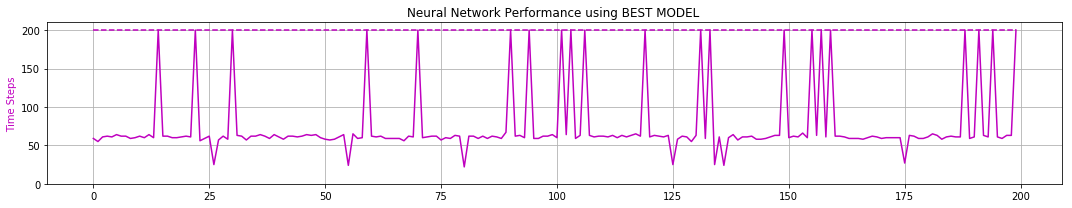

peak memory: 1468.35 MiB, increment: 1048.56 MiB
0 -max- [ 0.854  2.041  0.209  1.316]
0 -min- [-0.213 -0.822 -0.209 -1.399]

1 -max- [ 0.843  1.900  0.209  1.303]
1 -min- [-0.190 -1.117 -0.209 -1.384]

2 -max- [ 0.882  2.084  0.209  1.430]
2 -min- [-0.197 -0.827 -0.209 -1.410]

3 -max- [ 0.799  2.256  0.209  1.630]
3 -min- [-0.193 -1.117 -0.209 -1.912]

4 -max- [ 0.848  2.033  0.209  1.362]
4 -min- [-0.191 -0.830 -0.209 -1.386]

5 -max- [ 0.826  1.895  0.209  1.100]
5 -min- [-0.221 -0.642 -0.209 -1.415]

6 -max- [ 0.858  2.023  0.209  1.472]
6 -min- [-0.193 -0.959 -0.209 -1.415]

7 -max- [ 0.856  2.035  0.209  1.658]
7 -min- [-0.207 -1.145 -0.209 -1.471]

8 -max- [ 0.861  2.016  0.209  1.411]
8 -min- [-0.215 -0.841 -0.209 -1.410]

9 -max- [ 0.840  2.038  0.209  1.099]
9 -min- [-0.199 -0.643 -0.209 -1.416]

Quantization TIME:  0.01 minutes


ITERATION # 26
SMALLEST TIMESTEP in ITERATION 26: 58
REAL TIME TO GENERATE 159659 EXPERIENCES:0:00:04.194222


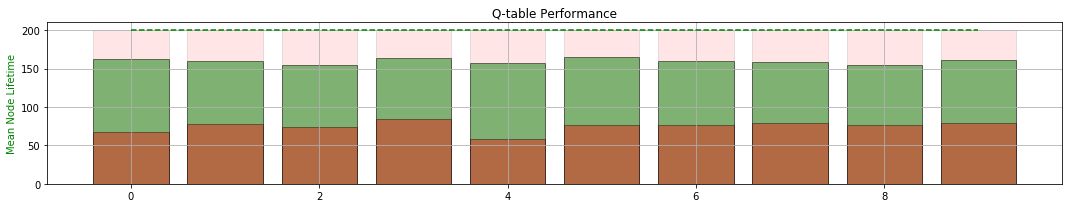

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.687	LOSS : 1.120	LOSS : 1.626	LOSS : 1.120	LOSS : 1.478	LOSS : 1.372	LOSS : 1.151	LOSS : 0.933	LOSS : 1.113	LOSS : 1.102	LOSS : 1.203	LOSS : 1.026	LOSS : 1.597	LOSS : 1.176	LOSS : 1.159	LOSS : 1.227	LOSS : 1.329	LOSS : 1.247	LOSS : 1.059	LOSS : 1.176	LOSS : 1.076	LOSS : 1.390	LOSS : 1.184	LOSS : 1.635	LOSS : 0.947	LOSS : 1.575	LOSS : 1.442	LOSS : 1.136	LOSS : 1.379	LOSS : 1.230	
Validating... MEAN TIME:  123.235
LOSS : 0.989	LOSS : 1.220	LOSS : 0.922	LOSS : 1.195	LOSS : 1.065	LOSS : 1.266	LOSS : 1.311	LOSS : 1.262	LOSS : 1.294	LOSS : 1.156	LOSS : 1.244	LOSS : 1.240	LOSS : 1.492	LOSS : 1.200	LOSS : 1.013	LOSS : 1.483	LOSS : 1.457	LOSS : 1.632	LOSS : 1.219	LOSS : 1.340	LOSS : 1.218	LOSS : 1.581	LOSS : 1.184	LOSS : 1.054	LOSS : 1.277	LOSS : 1.250	LOSS : 1.632	LOSS : 1.469	LOSS : 1.311	LOSS : 1.146	
Validating... MEAN TIME:  173.995
LOSS : 1.206	LOSS : 1

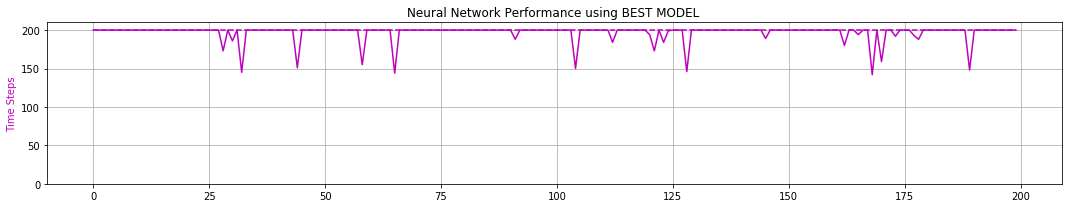

peak memory: 1519.19 MiB, increment: 1050.26 MiB
0 -max- [ 0.594  1.705  0.209  1.309]
0 -min- [-0.285 -1.367 -0.209 -1.334]

1 -max- [ 0.573  1.704  0.209  1.045]
1 -min- [-0.336 -1.320 -0.209 -1.366]

2 -max- [ 0.600  1.694  0.209  1.287]
2 -min- [-0.276 -1.333 -0.209 -1.333]

3 -max- [ 0.558  1.711  0.209  1.062]
3 -min- [-0.290 -1.366 -0.209 -1.362]

4 -max- [ 0.577  1.682  0.209  1.242]
4 -min- [-0.276 -1.337 -0.209 -1.249]

5 -max- [ 0.559  1.701  0.209  1.046]
5 -min- [-0.296 -1.329 -0.209 -1.380]

6 -max- [ 0.579  1.700  0.209  1.238]
6 -min- [-0.273 -1.361 -0.209 -1.322]

7 -max- [ 0.561  1.708  0.208  1.058]
7 -min- [-0.351 -1.502 -0.209 -1.426]

8 -max- [ 0.605  1.685  0.209  1.145]
8 -min- [-0.268 -1.361 -0.209 -1.373]

9 -max- [ 0.554  1.727  0.209  1.058]
9 -min- [-0.283 -1.326 -0.209 -1.404]

Quantization TIME:  0.01 minutes


ITERATION # 27
SMALLEST TIMESTEP in ITERATION 27: 23
REAL TIME TO GENERATE 91992 EXPERIENCES:0:00:02.084774


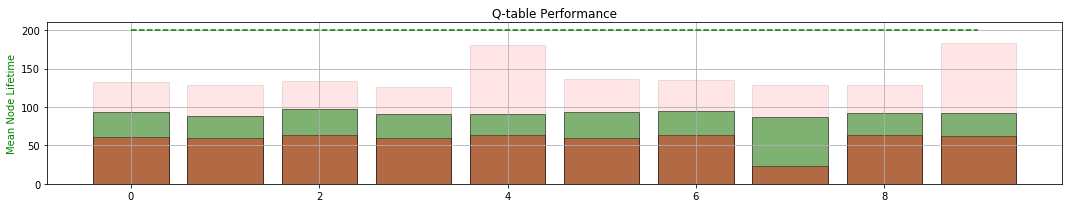

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.140	LOSS : 1.159	LOSS : 1.334	LOSS : 1.220	LOSS : 1.337	LOSS : 1.180	LOSS : 0.861	LOSS : 1.508	LOSS : 1.211	LOSS : 0.821	LOSS : 1.690	LOSS : 1.320	LOSS : 1.265	LOSS : 1.220	LOSS : 1.215	LOSS : 1.487	LOSS : 1.456	LOSS : 1.190	LOSS : 1.471	LOSS : 1.509	LOSS : 1.422	LOSS : 1.350	LOSS : 1.377	LOSS : 1.462	LOSS : 1.282	LOSS : 1.314	LOSS : 1.142	LOSS : 0.890	LOSS : 1.418	LOSS : 1.676	
Validating... MEAN TIME:  197.16
LOSS : 1.184	LOSS : 1.795	LOSS : 1.463	LOSS : 1.524	LOSS : 0.937	LOSS : 1.698	LOSS : 1.311	LOSS : 1.389	LOSS : 1.128	LOSS : 1.078	LOSS : 1.186	LOSS : 1.193	LOSS : 1.022	LOSS : 1.446	LOSS : 0.846	LOSS : 1.121	LOSS : 0.950	LOSS : 1.022	LOSS : 1.109	LOSS : 1.141	LOSS : 1.338	LOSS : 1.320	LOSS : 1.729	LOSS : 1.065	LOSS : 1.434	LOSS : 1.264	LOSS : 1.138	LOSS : 1.466	LOSS : 1.106	LOSS : 1.275	
Validating... MEAN TIME:  193.97
LOSS : 1.194	LOSS : 1.5

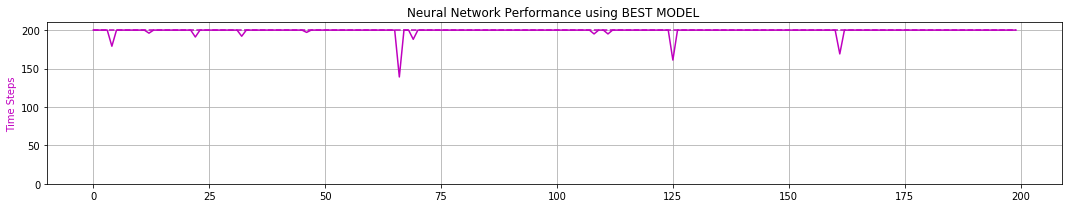

peak memory: 1453.52 MiB, increment: 1034.98 MiB
0 -max- [ 0.440  2.248  0.209  1.330]
0 -min- [-0.732 -1.364 -0.209 -1.537]

1 -max- [ 0.371  2.091  0.209  1.054]
1 -min- [-0.765 -1.310 -0.209 -1.601]

2 -max- [ 0.430  1.911  0.209  1.077]
2 -min- [-0.709 -1.460 -0.209 -1.412]

3 -max- [ 0.401  1.911  0.209  0.993]
3 -min- [-0.853 -1.453 -0.209 -1.428]

4 -max- [ 0.392  1.901  0.209  1.092]
4 -min- [-0.831 -1.335 -0.209 -1.410]

5 -max- [ 0.380  2.067  0.209  1.027]
5 -min- [-0.774 -1.347 -0.209 -1.609]

6 -max- [ 0.417  1.889  0.209  1.098]
6 -min- [-0.720 -1.518 -0.209 -1.404]

7 -max- [ 0.375  2.080  0.209  0.988]
7 -min- [-0.885 -1.498 -0.209 -1.541]

8 -max- [ 0.382  1.891  0.209  1.288]
8 -min- [-0.726 -1.483 -0.209 -1.408]

9 -max- [ 0.386  1.907  0.209  0.859]
9 -min- [-0.844 -1.339 -0.208 -1.689]

Quantization TIME:  0.01 minutes


ITERATION # 28
SMALLEST TIMESTEP in ITERATION 28: 15
REAL TIME TO GENERATE 74563 EXPERIENCES:0:00:01.706913


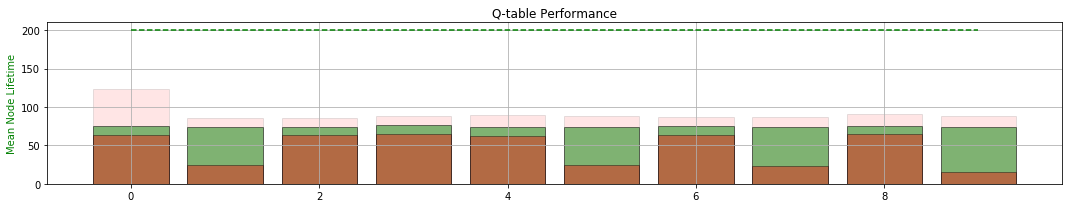

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.201	LOSS : 1.052	LOSS : 1.106	LOSS : 0.884	LOSS : 1.343	LOSS : 1.110	LOSS : 0.953	LOSS : 0.986	LOSS : 1.404	LOSS : 1.139	LOSS : 1.151	LOSS : 1.144	LOSS : 1.278	LOSS : 1.300	LOSS : 1.397	LOSS : 1.081	LOSS : 1.070	LOSS : 1.191	LOSS : 1.391	LOSS : 1.208	LOSS : 1.273	LOSS : 1.186	LOSS : 1.263	LOSS : 1.138	LOSS : 1.124	LOSS : 1.183	LOSS : 1.069	LOSS : 1.122	LOSS : 1.104	LOSS : 1.217	
Validating... MEAN TIME:  129.815
LOSS : 0.972	LOSS : 0.878	LOSS : 1.012	LOSS : 1.327	LOSS : 1.064	LOSS : 1.424	LOSS : 0.954	LOSS : 0.931	LOSS : 1.347	LOSS : 1.301	LOSS : 1.380	LOSS : 1.339	LOSS : 1.211	LOSS : 1.247	LOSS : 1.101	LOSS : 1.462	LOSS : 0.865	LOSS : 1.092	LOSS : 1.718	LOSS : 1.271	LOSS : 1.182	LOSS : 0.947	LOSS : 1.184	LOSS : 1.561	LOSS : 0.944	LOSS : 0.911	LOSS : 1.195	LOSS : 1.409	LOSS : 1.126	LOSS : 1.067	
Validating... MEAN TIME:  103.94
LOSS : 0.685	LOSS : 1.

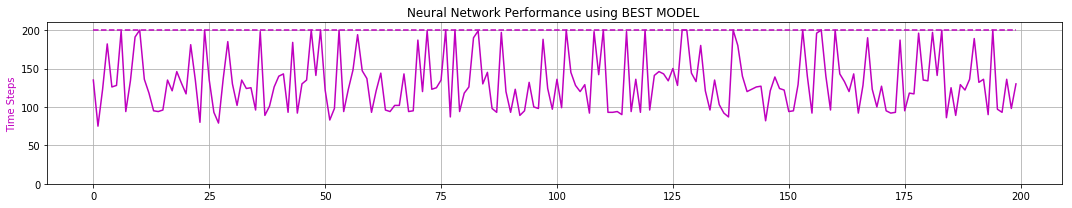

peak memory: 1437.29 MiB, increment: 1035.48 MiB
0 -max- [ 0.310  2.211  0.209  1.280]
0 -min- [-1.412 -2.191 -0.204 -1.663]

1 -max- [ 0.201  0.765  0.209  1.374]
1 -min- [-1.389 -2.259 -0.208 -1.287]

2 -max- [ 0.187  0.815  0.209  1.175]
2 -min- [-1.277 -2.007 -0.192 -1.031]

3 -max- [ 0.178  0.768  0.209  1.323]
3 -min- [-1.347 -2.075 -0.199 -1.059]

4 -max- [ 0.187  0.634  0.209  1.358]
4 -min- [-1.243 -2.050 -0.189 -0.891]

5 -max- [ 0.175  0.800  0.209  1.180]
5 -min- [-1.464 -2.216 -0.208 -1.180]

6 -max- [ 0.191  0.632  0.209  1.107]
6 -min- [-1.291 -2.018 -0.189 -0.936]

7 -max- [ 0.189  0.795  0.209  1.224]
7 -min- [-1.368 -2.046 -0.209 -1.142]

8 -max- [ 0.185  0.629  0.209  1.115]
8 -min- [-1.236 -1.856 -0.191 -0.876]

9 -max- [ 0.172  0.754  0.209  1.110]
9 -min- [-1.371 -2.071 -0.209 -1.481]

Quantization TIME:  0.01 minutes


ITERATION # 29
SMALLEST TIMESTEP in ITERATION 29: 17
REAL TIME TO GENERATE 82239 EXPERIENCES:0:00:01.938636


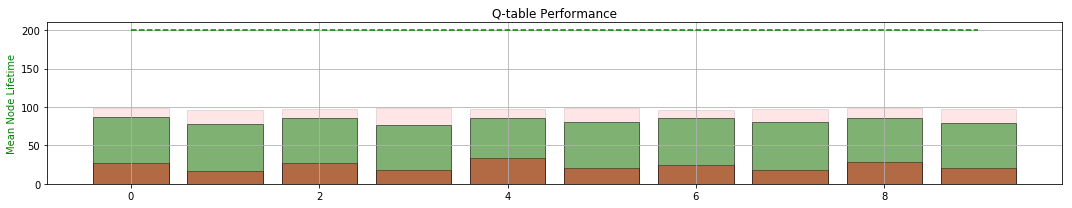

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  1e-05
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.551	LOSS : 1.232	LOSS : 1.351	LOSS : 1.449	LOSS : 1.454	LOSS : 1.531	LOSS : 1.825	LOSS : 0.750	LOSS : 1.571	LOSS : 1.298	LOSS : 1.487	LOSS : 1.255	LOSS : 1.054	LOSS : 1.160	LOSS : 1.280	LOSS : 1.641	LOSS : 1.308	LOSS : 1.185	LOSS : 1.085	LOSS : 1.558	LOSS : 1.321	LOSS : 1.749	LOSS : 1.330	LOSS : 1.715	LOSS : 1.508	LOSS : 1.252	LOSS : 1.443	LOSS : 1.656	LOSS : 1.808	LOSS : 1.271	
Validating... MEAN TIME:  93.98
LOSS : 1.394	LOSS : 1.705	LOSS : 1.723	LOSS : 1.911	LOSS : 1.578	LOSS : 1.048	LOSS : 1.260	LOSS : 1.623	LOSS : 0.828	LOSS : 1.198	LOSS : 1.639	LOSS : 1.478	LOSS : 1.503	LOSS : 1.012	LOSS : 1.232	LOSS : 1.332	LOSS : 1.510	LOSS : 1.007	LOSS : 1.715	LOSS : 1.572	LOSS : 1.593	LOSS : 1.302	LOSS : 1.245	LOSS : 1.460	LOSS : 1.790	LOSS : 1.377	LOSS : 1.483	LOSS : 1.674	LOSS : 1.173	LOSS : 1.302	
Validating... MEAN TIME:  95.88
LOSS : 1.065	LOSS : 1.283

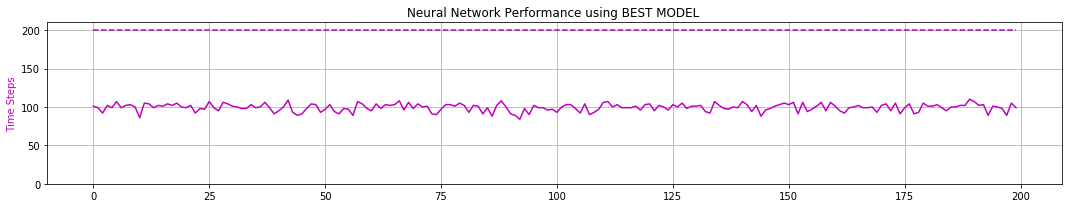

peak memory: 1442.34 MiB, increment: 972.17 MiB
0 -max- [ 0.209  0.631  0.209  1.686]
0 -min- [-2.156 -3.143 -0.205 -0.958]

1 -max- [ 0.188  0.829  0.209  1.680]
1 -min- [-2.301 -3.344 -0.209 -1.178]

2 -max- [ 0.191  0.815  0.209  1.681]
2 -min- [-2.154 -3.149 -0.209 -1.028]

3 -max- [ 0.191  0.820  0.209  1.723]
3 -min- [-2.394 -3.360 -0.209 -1.197]

4 -max- [ 0.167  0.635  0.209  1.668]
4 -min- [-2.238 -3.153 -0.209 -0.966]

5 -max- [ 0.190  0.829  0.209  1.717]
5 -min- [-2.349 -3.543 -0.209 -1.225]

6 -max- [ 0.184  0.636  0.209  1.687]
6 -min- [-2.178 -3.141 -0.209 -0.996]

7 -max- [ 0.193  0.828  0.209  1.755]
7 -min- [-2.370 -3.531 -0.209 -1.271]

8 -max- [ 0.171  0.633  0.209  1.674]
8 -min- [-2.177 -2.960 -0.209 -0.966]

9 -max- [ 0.203  0.831  0.209  1.682]
9 -min- [-2.303 -3.329 -0.209 -1.283]

Quantization TIME:  0.01 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################

    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  4615.0
Total Serial Timesteps   :  2081384.0
Speed-up                 :  451.00


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   985 FAILURE  17  30    4615    2081384     451.00
